# Νευρωνικά Δίκτυα

Παρακάτω θα παρουσιάσουμε μερικές αρχιτεκτονικές νευρωνικών δικτύων.

***

## Συναρτήσεις 

Οι παρακάτω βοηθητικές συναρτήσεις θα χρησιμοποιηθούν για να κάνουμε train και test το μοντέλο.

Αρχικά κάνουμε τα απαραίτητα imports και ορίζουμε την συσκευή που θα χρησιμοποιήσουμε (cpu/gpu).

In [1]:
import torch
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
from torch import nn
import pandas as pd
import os
from torch.optim import lr_scheduler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error
import xgboost as xgb

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device, imports complete!'.format(device))

BATCH_SIZE = 32

Using cpu device, imports complete!


Στην συνέχεια ορίζουμε την πρώτη συνάρτηση η οποία δέχεται ένα μοντέλο, το training dataset, την συνάρτηση λάθους, τον optimizer, και την συσκευή που χρησιμοποιούμε. Προχωράει το training κατά ένα βήμα και επιστρέφει την απώλεια.

In [2]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device = 'cpu'):
    model.to(device)
    model.train()

    train_loss = 0
    for X_batch, y_batch in data_loader:
        # Send data to GPU
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Forward pass
        y_pred = model(X_batch)

        # Compute loss
        loss = loss_fn(y_pred, y_batch)

        # Zero gradients
        optimizer.zero_grad()

        # Backward pass
        loss.backward()

        # Update the weights
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping to prevent gradients exploding
        optimizer.step()

        train_loss += loss.item()
    
    return train_loss


Ομοίως η παρακάτω συνάρτηση κάνει test το μοντέλο σε κάθε εποχή, και επιστρέφει την απώλεια.

In [3]:
def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device = 'cpu'):
    model.to(device)
    model.eval()

    test_loss = 0
    with torch.inference_mode():
        for X_batch, y_batch in data_loader:
            # Send data to GPU
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            y_test_pred = model(X_batch)
            test_loss += loss_fn(y_test_pred, y_batch).item()
    
    return test_loss

Σε αυτήν την περίπτωση δεν έχουμε κάνει scale τα output data 

In [4]:
def eval_model(model: torch.nn.Module, 
               data_loader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               device: torch.device = 'cpu',
               return_all = False):
    model.eval()
    all_preds = []
    all_targets = []

    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)

            y_pred = model(X)

            # Move to CPU and collect all predictions and targets
            all_preds.append(y_pred.cpu())
            all_targets.append(y.cpu())

    # Concatenate all batches
    all_preds = torch.cat(all_preds, dim=0).numpy()
    all_targets = torch.cat(all_targets, dim=0).numpy()

    # Calculate average Euclidean distance (in cm)
    distances = np.linalg.norm(all_preds - all_targets, axis=1)
    mean_distance_error = np.mean(distances)
    std_distance_error = np.std(distances)
    if(return_all):
        return {
            "model_name": model.__class__.__name__,
            "mean_distance_error_cm": mean_distance_error.item(),
            "std" : std_distance_error.item()
        }
    else:
        return mean_distance_error.item()

Η βασική συνάρτηση, επαναληπτικά για όσες εποχές έχουμε διαλέξει κάνει train και test το μοντέλο, και ανά 10 εποχές εκτυπώνει τα αποτελέσματα. Επιστρέφει 2 πίνακες με τις συνολικές απώλειες σε κάθε επανάληψη.

In [5]:
def train_test_model(epoch : int, 
                     model: torch.nn.Module,
                     loss_fn: torch.nn.Module,
                     optimizer: torch.optim.Optimizer,
                     scheduler,
                     train_loader: torch.utils.data.DataLoader,
                     test_loader: torch.utils.data.DataLoader = None,
                     device: torch.device = 'cpu',
                     test: bool = True,
                     seed: int = 42):
    torch.manual_seed(seed)
    train_loss_arr = []
    test_loss_arr = []
    error_dist_train = []
    error_dist_test = []
    if(test):
        for epochs in range(epoch):
            epoch_loss = train_step(model, train_loader, loss_fn, optimizer, device)
            train_loss_arr.append(epoch_loss / len(train_loader))

            scheduler.step(epoch_loss)
            after_lr = optimizer.param_groups[0]['lr']
            
            test_loss = test_step(model, test_loader, loss_fn, device)
            test_loss_arr.append(test_loss / len(test_loader))
            error_dist_train.append(eval_model(model,train_loader,loss_fn,device))
            error_dist_test.append(eval_model(model,test_loader,loss_fn,device))
            if (epochs) % 10 == 0 or epochs == 0:
                print(f'Epoch {epochs} | Loss train: {train_loss_arr[-1]} | Loss test: {test_loss_arr[-1]} | lr = {after_lr}')
            elif epochs + 1 == epoch:
                print(f'Epoch {epoch} | Loss train: {train_loss_arr[-1]} | Loss test: {test_loss_arr[-1]} | lr = {after_lr}')
        return train_loss_arr, test_loss_arr, error_dist_train, error_dist_test
    else:
        for epochs in range(epoch):
            epoch_loss = train_step(model, train_loader, loss_fn, optimizer, device)
            train_loss_arr.append(epoch_loss / len(train_loader))
            error_dist_train.append(eval_model(model,train_loader,loss_fn,device))
            scheduler.step(epoch_loss)
            after_lr = optimizer.param_groups[0]['lr']
            if (epochs) % 10 == 0 or epochs == 0:
                print(f'Epoch {epochs} | Loss train: {train_loss_arr[-1]} | lr = {after_lr}')
            elif epochs + 1 == epoch:
                print(f'Epoch {epoch} | Loss train: {train_loss_arr[-1]} | lr = {after_lr}')
        return train_loss_arr,error_dist_train


Η συνάρτηση είναι παρόμοια με την test_step με την διαφορά ότι επιστρέφει ένα dictionary με τα βασικά στοιχεία του μοντέλου.

Η συνάρτηση αυτή χρησιμοποιείται για να εμφανίσει τις κανονικοποιημένες στο (0,1) train_loss και test_loss curves.

In [6]:
def plot_results(train_arr, test_arr, error_train,error_test):
    # Plot the loss curves
    if(np.max(train_arr) != np.min(train_arr)):
        train_arr = (train_arr - np.min(train_arr)) / (np.max(train_arr) - np.min(train_arr))
    else:
        print("Min and max of train array are the same")
        print(train_arr)
        return
    if(np.max(test_arr) != np.min(test_arr)):
        test_arr = (test_arr - np.min(test_arr)) / (np.max(test_arr) - np.min(test_arr))
    else:
        print("Min and Max of test array are the same")
        print(test_arr)
        return


    lin = np.linspace(0,1,len(train_arr))

    axis1 = plt.subplot(211)
    axis2 = plt.subplot(212)
    axis1.plot(lin,train_arr,color='red',label = 'Train loss')
    axis1.plot(lin,test_arr,color='blue',label="Test loss")
    axis1.set_xlabel('epochs')
    axis1.set_ylabel('Normalized loss')
    axis1.set_title('Train and test loss per epoch')
    axis1.legend()
    axis1.grid(True)
    
    axis2.plot(lin,error_test,color='red',label = 'Train error')
    axis2.plot(lin,error_test,color='blue',label="Test error")
    axis2.set_xlabel('epochs')
    axis2.set_ylabel('error')
    axis2.set_title('Train and test error per epoch')
    axis2.legend()
    axis2.grid(True)
    
    plt.tight_layout()
    plt.show()

***

## Εισαγωγή δεδομένων

Η συνάρτηση αυτή δέχεται τα paths των δεδομένων, δημιουργεί και επιστρέφει τα mini_batches που θα χρησιμοποιηθούν στο training.

ΣΟΣ Να αλλάξουμε το scaling method

In [7]:
def data_func(input_array, labels, batch_size = BATCH_SIZE, test_size = 0.2):
    # Reshape the tensor to 2D so that it can be used in the linear model
    X = input_array.reshape(len(input_array), -1)
    y = labels

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    
    scaler = StandardScaler()
    # Fit the scaler on the training data and transform both the training and test sets
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Transform the data to PyTorch tensors and move them to the GPU if available
    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

    # Define the dataset
    train_data = TensorDataset(X_train_tensor, y_train_tensor)
    test_data = TensorDataset(X_test_tensor, y_test_tensor)

    # Define the data loader
    train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True) 
    test_loader = DataLoader(dataset=test_data, batch_size=batch_size)

    return train_loader, test_loader

Ανάλογα με τον ποιον φάκελο θέλουμε να διαβάσουμε αλλάζουμε το νουμεράκι.

In [8]:
# Define the pickle file name and relative path
pickle_name = "Sim_Data_Noisy_Interp.pkl"
folder_name = "Sim_Data_0"  # Change accordingly

relative_path = os.path.join("..", "Simulation", folder_name, pickle_name)

# Resolve the absolute path
file_path = os.path.abspath(relative_path)

try:
    # Check if the file exists before attempting to read
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"File not found: {file_path}")
    
    # Load the pickle file
    df = pd.read_pickle(file_path)
except Exception as e:
    print(f"An unexpected error occurred: {e}")

df.head()


,tag_pos,Antenna,robot_pos,Phases
0,"[1.3374070790110344, 0.1, 0.1]",[0],"[0.6625929209889657, 0.6661549086159794, 0.669...","[0.0, -0.10487150506512838, -0.221901548402660..."
1,"[1.9494820917610742, 0.1, 0.1]",[0],"[0.05051790823892587, 0.054072937717603915, 0....","[0.0, -0.10101337624334959, -0.321809004322664..."
2,"[0.4116242295452528, 0.1, 0.1]",[0],"[1.5883757704547472, 1.5920683760992664, 1.595...","[0.0, -0.13453695823921752, -0.255845581716036..."
3,"[1.2026705067177903, 0.1, 0.1]",[0],"[0.7973294932822097, 0.80090229956099, 0.80447...","[0.0, -0.14502076970326194, -0.377630922159475..."
4,"[1.4467800565600593, 0.1, 0.1]",[0],"[0.5532199434399407, 0.5567733429395528, 0.560...","[0.0, -0.12889416459989012, -0.239887498367972..."


Δημιουργούμε τα training και testing sets.

In [9]:
rfid_label = np.array(df['tag_pos'].tolist())[:, :2] 
rfid_label.shape

(10000, 2)

In [10]:
# Convert columns to NumPy arrays
robot_pos_array = np.stack(df["robot_pos"].to_numpy())  # Shape: (10000, 400)
phases_array = np.stack(df["Phases"].to_numpy())  # Shape: (10000, 400)

# Concatenate along the last axis
info_tensor = np.stack((robot_pos_array, phases_array), axis=-1)  # Shape: (10000, 400, 2)
info_tensor.shape

(10000, 400, 2)

Ουσιαστικά αναζητούμε τα **Χ και Υ** του RFID TAG, γνωρίζοντας το πως κινήθηκε κατά τον άξονα **Χ** και την μέτρηση της **φάσης** του.

In [11]:
train_loader, test_loader = data_func(info_tensor, rfid_label)

In [12]:
len(train_loader) # Should be (total_tags / batch_size) * train_partition 

250

Αποθηκεύουμε σε μεταβλητές τα μεγέθη του input και του output για τα γραμμικά μοντέλα.

In [13]:
output_len = rfid_label.shape[1]
input_len = info_tensor.shape[1] * info_tensor.shape[2]

input_len,output_len

(800, 2)

***

## Φακελοποίηση και αποθήκευση μοντέλων

In [14]:
from pathlib import Path

# Get the directory of the script
parent_dir = Path(__file__).parent if "__file__" in globals() else Path.cwd()

# Initialize a list to store the indices
existing_indices = []

# Iterate through the folders in the directory
for folder in parent_dir.iterdir():
    if folder.is_dir() and folder.name.startswith("NN_Data_"):  # Check if it's a directory and follows the pattern
        try:
            index = int(folder.name[len("NN_Data_"):])  # Extract the number part
            existing_indices.append(index)
        except ValueError:
            pass  # Ignore folders that don't have a valid integer index

# Determine the next index
new_index = (max(existing_indices) + 1) if existing_indices else 0

# Create the new folder
new_folder_path = parent_dir / f"NN_Data_{new_index}"
new_folder_path.mkdir(exist_ok=True)

print(f"Created folder: {new_folder_path}")

Created folder: c:\Users\giama\Desktop\ece_auth\semester10\NNs-on-RFID-Localization\Neural_Networks\NN_Data_10


In [15]:

def save_model_info(model:nn.Module,filename):
    p = Path(f"{filename}.pt")
    torch.save(model.state_dict(),p)

def load_model_info(model,filename):
    if not isinstance(filename,Path):
        p = Path(filename)
        if(p.exists()):
            model.load_state_dict(torch.load(p))
        else:
            print(f"{filename} doesn't exist")
    else:
        model.load_state_dict(torch.load(filename,map_location=device))
    return model

##  Cross-Validation

In [16]:
def cv_NN(model_class: torch.nn.Module, 
          model_params,
        X: np.ndarray,
        y: np.ndarray,
        splits: int, 
        loss_fn: torch.nn.Module,
        optimizer_class: torch.optim.Optimizer,
        optimizer_params,
        scheduler_class,
        scheduler_params, 
        device=device,
        random_state: int = 42):
    final_errors = []
    for i in range(splits):
        model = model_class(**model_params)
        optimizer = optimizer_class(model.parameters(),**optimizer_params)

        scheduler = None
        if scheduler_class is not None and scheduler_params is not None:
            scheduler = scheduler_class(optimizer, **scheduler_params)
        split_set = np.vsplit(X,splits)
        split_lab = np.vsplit(y,splits)

        test_data = split_set[i]
        test_labels = split_lab[i]
        split_set.pop(i)
        split_lab.pop(i)
        train_data = np.vstack(split_set)
        train_labels = np.vstack(split_lab)
        tr_data = TensorDataset(torch.from_numpy(train_data).type(torch.float32).to(device),torch.from_numpy(train_labels).type(torch.float32).to(device))
        te_data = TensorDataset(torch.from_numpy(test_data).type(torch.float32).to(device),torch.from_numpy(test_labels).type(torch.float32).to(device))
        train_dataloader = DataLoader(tr_data,batch_size=BATCH_SIZE,shuffle=False)
        test_dataloader = DataLoader(te_data,batch_size=BATCH_SIZE,shuffle=False)

        train_loss, test_loss, train_err, test_err = train_test_model(epoch = 100,model = model, train_loader= train_dataloader, test_loader= test_dataloader, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler, device=device)
        final_errors.append(test_err[-1])
        plot_results(train_loss, test_loss,train_err,test_err)
    return np.array(final_errors)


Shuffle the dataset because we don't want it to be ordered

In [17]:
X = info_tensor.reshape(len(info_tensor), -1)
indices = np.arange(len(info_tensor))
np.random.shuffle(indices)
y = rfid_label
X = X[indices,:]
y = y[indices,:]

train_whole_data = TensorDataset(torch.from_numpy(X).type(torch.float32).to(device),torch.from_numpy(y).type(torch.float32).to(device))
train_whole_dataloader = DataLoader(train_whole_data,batch_size=BATCH_SIZE,shuffle=False)
print(len(train_whole_dataloader))

313


## Αρχιτεκτονικές

### Αρχιτεκτονική 1

Το πρώτο μας μοντέλο θα είναι η απλούστερη περίπτωση ενός γραμμικού layer με είσοδο το ```input_size``` δηλαδή 4000 (για την ώρα) , και έξοδο 2 (x,y), χωρίς για αρχή κάποια συνάρτηση ενεργοποίησης.

Σαν συνάρτηση λάθους θα χρησιμοποιηθεί η ```MSELoss``` ενώ σαν optimizers θα δοκιμαστούν οι ```Adam```, ```RMSProp```, ```SGD```.

In [18]:
class SimpleModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(SimpleModel, self).__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(in_features= input_size, out_features= output_size),  
        )
    
    def forward(self, x):
        return self.linear_stack(x)

Epoch 0 | Loss train: 53.35304325008392 | Loss test: 44.30891636439732 | lr = 0.01
Epoch 10 | Loss train: 22.875597507476808 | Loss test: 9.906146602025109 | lr = 0.01
Epoch 20 | Loss train: 0.6099845013022422 | Loss test: 0.49429352084795636 | lr = 0.001
Epoch 30 | Loss train: 0.6119068021178246 | Loss test: 0.3772317136800478 | lr = 0.001
Epoch 40 | Loss train: 0.27358761620521543 | Loss test: 0.3114812330357612 | lr = 0.0001
Epoch 50 | Loss train: 0.27738771024346354 | Loss test: 0.36271875186098945 | lr = 0.0001
Epoch 60 | Loss train: 0.27387278217077254 | Loss test: 0.2771832126946676 | lr = 1e-05
Epoch 70 | Loss train: 0.2446652466058731 | Loss test: 0.27370093218863956 | lr = 1e-05
Epoch 80 | Loss train: 0.2427271701991558 | Loss test: 0.2702073432386868 | lr = 1.0000000000000002e-06
Epoch 90 | Loss train: 0.2426223325431347 | Loss test: 0.27009450797996826 | lr = 1.0000000000000002e-07
Epoch 100 | Loss train: 0.24243862006068229 | Loss test: 0.27004179334829725 | lr = 1.0000000

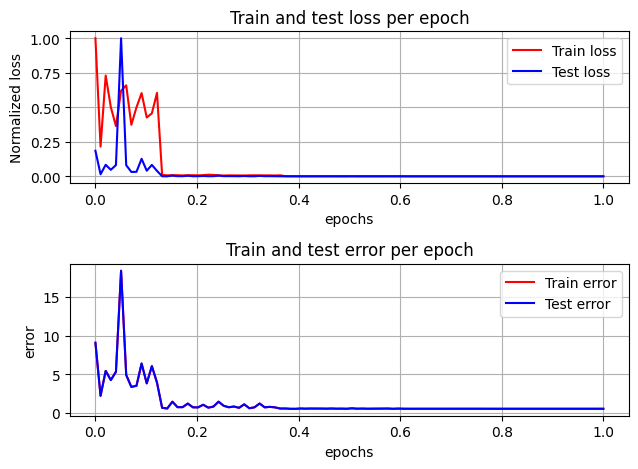

Epoch 0 | Loss train: 45.10983697295189 | Loss test: 29.033059528895787 | lr = 0.01
Epoch 10 | Loss train: 21.89382346153259 | Loss test: 1.3582511790215024 | lr = 0.01
Epoch 20 | Loss train: 22.889334305763246 | Loss test: 14.83573986235119 | lr = 0.001
Epoch 30 | Loss train: 0.6144290961027146 | Loss test: 0.9595590077695393 | lr = 0.001
Epoch 40 | Loss train: 0.2747024291455746 | Loss test: 0.23641990373531976 | lr = 0.0001
Epoch 50 | Loss train: 0.28993549513816835 | Loss test: 0.24820258007163093 | lr = 0.0001
Epoch 60 | Loss train: 0.2493628674149513 | Loss test: 0.23608427814074925 | lr = 1e-05
Epoch 70 | Loss train: 0.24498863083124162 | Loss test: 0.23066475360639513 | lr = 1.0000000000000002e-06
Epoch 80 | Loss train: 0.245127563893795 | Loss test: 0.23084212685861286 | lr = 1.0000000000000002e-06
Epoch 90 | Loss train: 0.2446416573226452 | Loss test: 0.23055022150751145 | lr = 1.0000000000000002e-07
Epoch 100 | Loss train: 0.2445973285138607 | Loss test: 0.230536410851138 | 

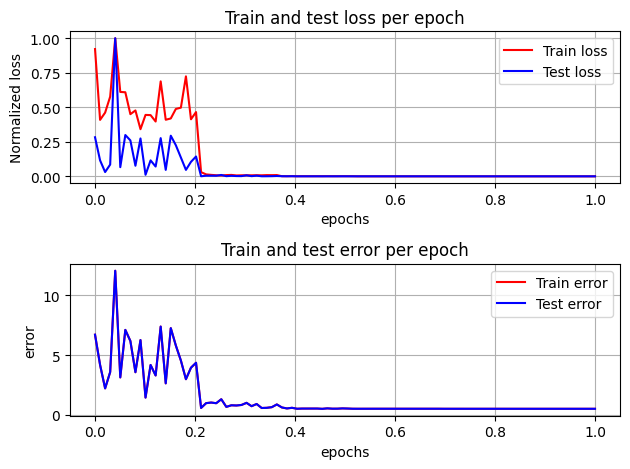

Epoch 0 | Loss train: 45.921562313318255 | Loss test: 23.242905480521067 | lr = 0.01
Epoch 10 | Loss train: 57.735108990669254 | Loss test: 109.15433611188617 | lr = 0.01
Epoch 20 | Loss train: 24.227060914039612 | Loss test: 10.380050212617904 | lr = 0.01
Epoch 30 | Loss train: 0.5615458467006683 | Loss test: 0.8550739487012228 | lr = 0.001
Epoch 40 | Loss train: 0.7885467824935913 | Loss test: 0.5639211142820025 | lr = 0.001
Epoch 50 | Loss train: 0.2796747106611729 | Loss test: 0.26075399489629836 | lr = 0.0001
Epoch 60 | Loss train: 0.27718361592292784 | Loss test: 0.2529631686352548 | lr = 0.0001
Epoch 70 | Loss train: 0.24342841878533364 | Loss test: 0.25418662646460155 | lr = 1e-05
Epoch 80 | Loss train: 0.24343343785405158 | Loss test: 0.25411526149227504 | lr = 1.0000000000000002e-06
Epoch 90 | Loss train: 0.2397101108431816 | Loss test: 0.24869691545055025 | lr = 1.0000000000000002e-06
Epoch 100 | Loss train: 0.2394334672689438 | Loss test: 0.2488031146072206 | lr = 1.0000000

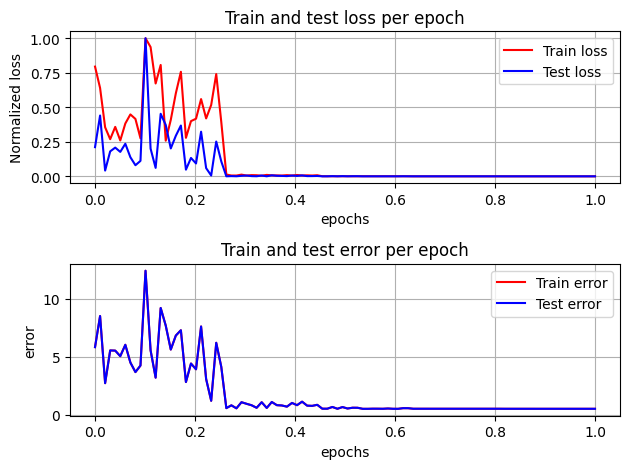

Epoch 0 | Loss train: 47.096953520059586 | Loss test: 58.342827872624476 | lr = 0.01
Epoch 10 | Loss train: 14.085681094646453 | Loss test: 85.14648909795852 | lr = 0.01
Epoch 20 | Loss train: 37.660318316221236 | Loss test: 25.586065458872962 | lr = 0.01
Epoch 30 | Loss train: 0.6552449595928193 | Loss test: 0.2920180308440375 | lr = 0.001
Epoch 40 | Loss train: 0.5642050682902336 | Loss test: 0.5002219894575695 | lr = 0.0001
Epoch 50 | Loss train: 0.275946159362793 | Loss test: 0.2491556235722133 | lr = 0.0001
Epoch 60 | Loss train: 0.27470760595798493 | Loss test: 0.24257371184371768 | lr = 0.0001
Epoch 70 | Loss train: 0.2465187668800354 | Loss test: 0.24747517030863536 | lr = 1e-05
Epoch 80 | Loss train: 0.24612392002344133 | Loss test: 0.247145372605513 | lr = 1e-05
Epoch 90 | Loss train: 0.24183911383152007 | Loss test: 0.24060355907394773 | lr = 1.0000000000000002e-06
Epoch 100 | Loss train: 0.24155326715111733 | Loss test: 0.24067377121675582 | lr = 1.0000000000000002e-07


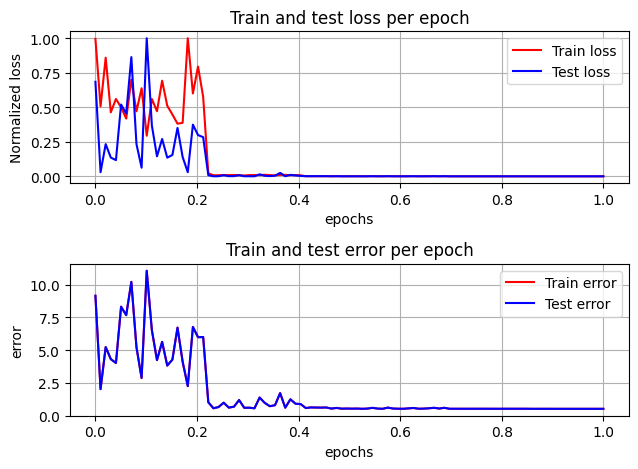

Epoch 0 | Loss train: 48.83977965092659 | Loss test: 3.5719269760071284 | lr = 0.01
Epoch 10 | Loss train: 36.87403335475921 | Loss test: 9.420209521339054 | lr = 0.01
Epoch 20 | Loss train: 0.645998363673687 | Loss test: 1.905834586847396 | lr = 0.001
Epoch 30 | Loss train: 0.7736536452770233 | Loss test: 0.5054401968206678 | lr = 0.001
Epoch 40 | Loss train: 0.26400824782252313 | Loss test: 0.2746849762541907 | lr = 0.0001
Epoch 50 | Loss train: 0.2604419503211975 | Loss test: 0.2955040848917431 | lr = 0.0001
Epoch 60 | Loss train: 0.26010576862096785 | Loss test: 0.302353794139529 | lr = 0.0001
Epoch 70 | Loss train: 0.2427900915443897 | Loss test: 0.25664524970546604 | lr = 1e-05
Epoch 80 | Loss train: 0.24242152220010757 | Loss test: 0.25632397109080873 | lr = 1e-05
Epoch 90 | Loss train: 0.24239220547676085 | Loss test: 0.2563161063525412 | lr = 1e-05
Epoch 100 | Loss train: 0.2423702111840248 | Loss test: 0.25629144682297633 | lr = 1e-05


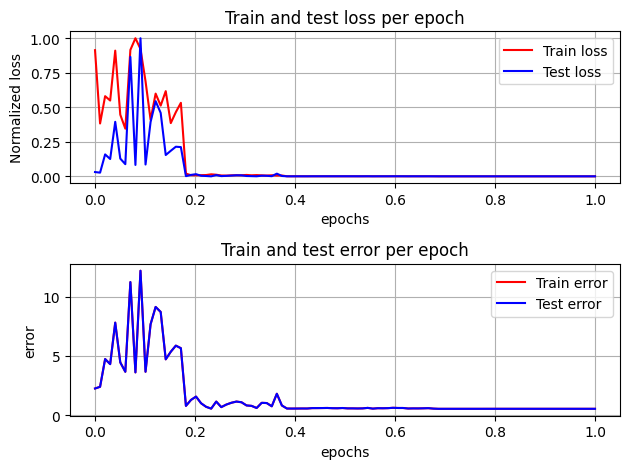

Completed CV with num splits: 5 and final error 0.5310508489608765


In [19]:
loss_fn = nn.MSELoss()

optimizer_params = {'lr':1e-2}
scheduler_params = {'mode':'min','factor':0.1,"patience":10}
model_params = {'input_size': input_len, 'output_size': output_len}
num_splits = 5
errors = cv_NN(model_class=SimpleModel,model_params=model_params,X=X,y=y,splits=num_splits,loss_fn=loss_fn,optimizer_class=torch.optim.Adam,optimizer_params=optimizer_params,scheduler_class=lr_scheduler.ReduceLROnPlateau,scheduler_params=scheduler_params,device=device)
print(f"Completed CV with num splits: {num_splits} and final error {np.mean(errors)}")

In [20]:
print(f"Completed CV with num splits: {num_splits} and final error {errors}")

Completed CV with num splits: 5 and final error [0.54099619 0.51315367 0.53434241 0.52553111 0.54123086]


Χρησιμοποιήσαμε τον optimizer ``` Adam ``` τώρα θα χρησιμοποιήσουμε τον ``` RMSProp```

Epoch 0 | Loss train: 3197.5831256103515 | Loss test: 610.9916008843315 | lr = 0.01
Epoch 10 | Loss train: 686.5404975585938 | Loss test: 604.0761389353919 | lr = 0.01
Epoch 20 | Loss train: 686.166916015625 | Loss test: 605.0887431795635 | lr = 0.01
Epoch 30 | Loss train: 685.9425324707031 | Loss test: 607.5795002286396 | lr = 0.01
Epoch 40 | Loss train: 685.7460361328125 | Loss test: 609.7999790736607 | lr = 0.01
Epoch 50 | Loss train: 685.5556934814454 | Loss test: 611.5202627030629 | lr = 0.01
Epoch 60 | Loss train: 685.3683011474609 | Loss test: 612.8357408311632 | lr = 0.01
Epoch 70 | Loss train: 685.1844260253906 | Loss test: 613.8826473175533 | lr = 0.01
Epoch 80 | Loss train: 685.0045288085937 | Loss test: 614.7392205132378 | lr = 0.01
Epoch 90 | Loss train: 684.8289711914063 | Loss test: 615.4794088696676 | lr = 0.01
Epoch 100 | Loss train: 684.6753132324219 | Loss test: 616.0710991753472 | lr = 0.01


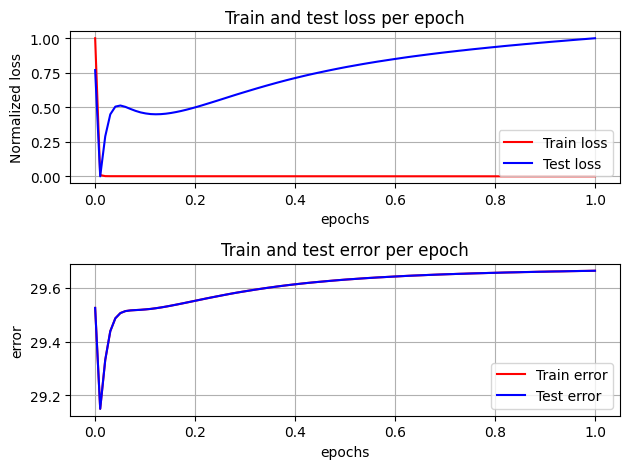

Epoch 0 | Loss train: 2399.0754049072266 | Loss test: 600.7503061445933 | lr = 0.01
Epoch 10 | Loss train: 683.257029296875 | Loss test: 591.7212839277964 | lr = 0.01
Epoch 20 | Loss train: 682.8145087890625 | Loss test: 595.8691338433159 | lr = 0.01
Epoch 30 | Loss train: 682.5290401611328 | Loss test: 597.8209368993365 | lr = 0.01
Epoch 40 | Loss train: 682.3430310058594 | Loss test: 597.9263019864521 | lr = 0.01
Epoch 50 | Loss train: 682.1168837890625 | Loss test: 597.3458760579427 | lr = 0.01
Epoch 60 | Loss train: 681.9450950927734 | Loss test: 597.0248345269097 | lr = 0.01
Epoch 70 | Loss train: 681.7824608154297 | Loss test: 596.6847219315786 | lr = 0.01
Epoch 80 | Loss train: 681.6159736328125 | Loss test: 596.7483176579551 | lr = 0.01
Epoch 90 | Loss train: 681.7681340332031 | Loss test: 601.3095073397197 | lr = 0.01
Epoch 100 | Loss train: 694.686654296875 | Loss test: 583.5615728469122 | lr = 0.01


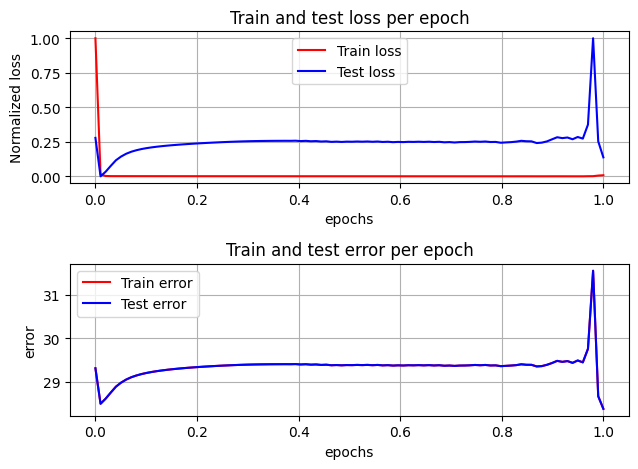

Epoch 0 | Loss train: 2405.0300142822266 | Loss test: 616.8943529885913 | lr = 0.01
Epoch 10 | Loss train: 686.0462305908203 | Loss test: 624.4531065925719 | lr = 0.01
Epoch 20 | Loss train: 685.4706007080079 | Loss test: 626.312486436632 | lr = 0.01
Epoch 30 | Loss train: 685.028373046875 | Loss test: 624.6168900747148 | lr = 0.01
Epoch 40 | Loss train: 684.6889833984375 | Loss test: 622.6895408024864 | lr = 0.01
Epoch 50 | Loss train: 684.40619921875 | Loss test: 620.9184158567398 | lr = 0.01
Epoch 60 | Loss train: 684.1587103271485 | Loss test: 619.3660612560454 | lr = 0.01


KeyboardInterrupt: 

In [21]:
loss_fn = nn.MSELoss()

optimizer_params = {'lr':1e-2}
scheduler_params = {'mode':'min','factor':0.1,"patience":10}
num_splits = 5
model_params = {'input_size': input_len, 'output_size': output_len}
errors = cv_NN(model_class=SimpleModel,model_params=model_params,X=X,y=y,splits=num_splits,loss_fn=loss_fn,optimizer_class=torch.optim.RMSprop,optimizer_params=optimizer_params,scheduler_class=lr_scheduler.ReduceLROnPlateau,scheduler_params=scheduler_params,device=device)
print(f"Completed CV with num splits: {num_splits} and final error {np.mean(errors)}")

Και τέλος χρησιμοποιούμε και τον ``` SGD ```

Epoch 0 | Loss train: 5.314210544705391 | Loss test: 1.6602981629825773 | lr = 0.01
Epoch 10 | Loss train: 4.5764224894046786 | Loss test: 2.994437503436255 | lr = 0.01
Epoch 20 | Loss train: 4.461212844371795 | Loss test: 7.772246398623028 | lr = 0.01
Epoch 30 | Loss train: 4.520173552989959 | Loss test: 1.639075553606427 | lr = 0.01
Epoch 40 | Loss train: 4.545459131479263 | Loss test: 2.670891008679829 | lr = 0.01
Epoch 50 | Loss train: 4.427613464355469 | Loss test: 7.75238093118819 | lr = 0.01
Epoch 60 | Loss train: 4.523976886272431 | Loss test: 1.5419768700523981 | lr = 0.01
Epoch 70 | Loss train: 4.564651614665985 | Loss test: 2.9482955100044372 | lr = 0.01
Epoch 80 | Loss train: 0.3731557422578335 | Loss test: 0.2867955281620934 | lr = 0.001
Epoch 90 | Loss train: 0.3637536097764969 | Loss test: 0.2962789088487625 | lr = 0.001
Epoch 100 | Loss train: 0.25619419652223585 | Loss test: 0.3068404377452911 | lr = 0.0001


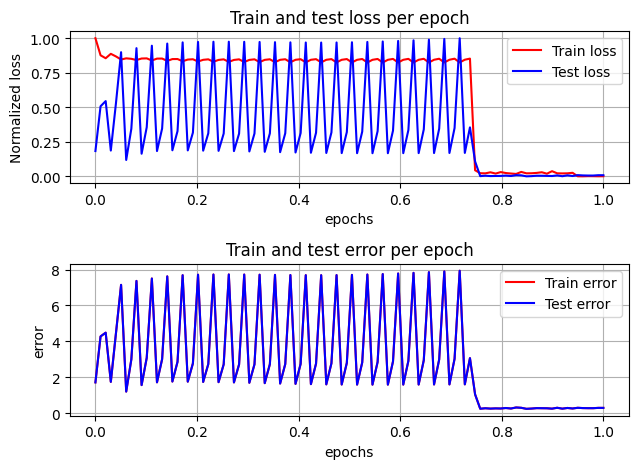

Epoch 0 | Loss train: 6.356550601363182 | Loss test: 3.652232877791874 | lr = 0.01
Epoch 10 | Loss train: 4.541055272817612 | Loss test: 1.7601408192089625 | lr = 0.01
Epoch 20 | Loss train: 4.505528713464737 | Loss test: 2.6783836285273233 | lr = 0.01
Epoch 30 | Loss train: 0.36052122604846953 | Loss test: 0.28790904333194095 | lr = 0.001
Epoch 40 | Loss train: 0.3760524282455444 | Loss test: 0.5258097277274207 | lr = 0.001
Epoch 50 | Loss train: 0.26414701727032663 | Loss test: 0.28946956282570246 | lr = 0.0001
Epoch 60 | Loss train: 0.26441364231705666 | Loss test: 0.29099647653481314 | lr = 0.0001
Epoch 70 | Loss train: 0.25307642060518265 | Loss test: 0.2582163323485662 | lr = 1e-05
Epoch 80 | Loss train: 0.25295251241326333 | Loss test: 0.2578861377541981 | lr = 1e-05
Epoch 90 | Loss train: 0.2528443177342415 | Loss test: 0.2576262855104038 | lr = 1e-05
Epoch 100 | Loss train: 0.25274753278493883 | Loss test: 0.2574213452282406 | lr = 1e-05


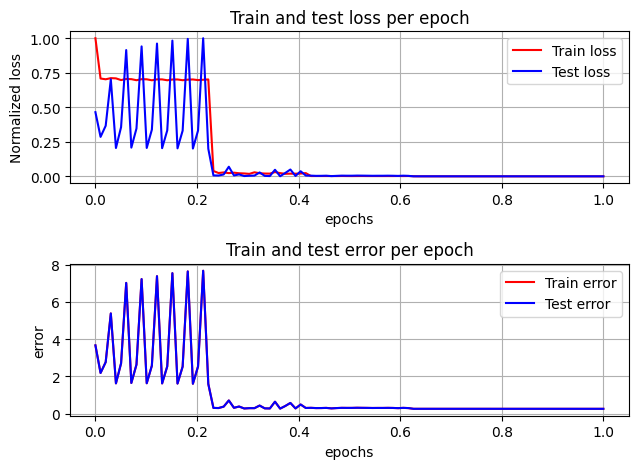

Epoch 0 | Loss train: 6.369889936387539 | Loss test: 4.605133030149672 | lr = 0.01
Epoch 10 | Loss train: 27.202771201848982 | Loss test: 43.11890132843502 | lr = 0.01
Epoch 20 | Loss train: 0.42410444194078445 | Loss test: 0.35482882483611033 | lr = 0.001
Epoch 30 | Loss train: 0.37895321983098984 | Loss test: 0.3373942838774787 | lr = 0.001
Epoch 40 | Loss train: 0.42027016299963 | Loss test: 0.4972636718598623 | lr = 0.001
Epoch 50 | Loss train: 0.26389790043234823 | Loss test: 0.33567384110083653 | lr = 0.0001
Epoch 60 | Loss train: 0.2643571973145008 | Loss test: 0.35806452352849266 | lr = 0.0001
Epoch 70 | Loss train: 0.2618543473780155 | Loss test: 0.33948562625381684 | lr = 0.0001
Epoch 80 | Loss train: 0.2609803871512413 | Loss test: 0.34355573178756804 | lr = 0.0001
Epoch 90 | Loss train: 0.2614423093497753 | Loss test: 0.346996538104519 | lr = 0.0001
Epoch 100 | Loss train: 0.2636747915148735 | Loss test: 0.3614835657534145 | lr = 0.0001


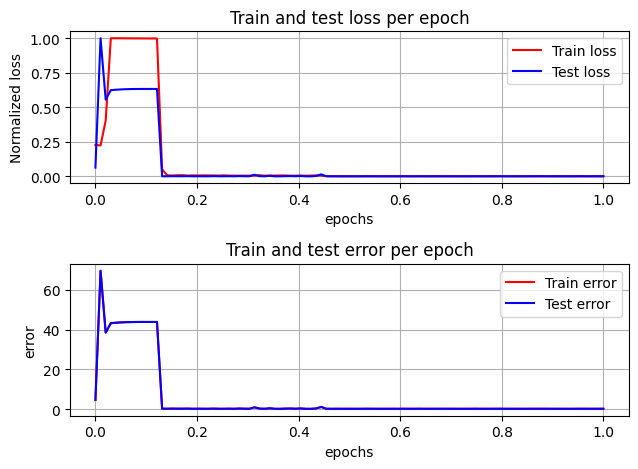

Epoch 0 | Loss train: 6.559882651090622 | Loss test: 16.638143282088024 | lr = 0.01
Epoch 10 | Loss train: 4.548301772356034 | Loss test: 7.5535553977603005 | lr = 0.01
Epoch 20 | Loss train: 4.539446007013321 | Loss test: 2.0203822151062982 | lr = 0.01
Epoch 30 | Loss train: 4.456988849878311 | Loss test: 3.7557873423137362 | lr = 0.01
Epoch 40 | Loss train: 4.501194655895233 | Loss test: 8.243404517098078 | lr = 0.01
Epoch 50 | Loss train: 0.43332649022340775 | Loss test: 1.0709558592902289 | lr = 0.001
Epoch 60 | Loss train: 0.3794705289900303 | Loss test: 0.2483525610868893 | lr = 0.001
Epoch 70 | Loss train: 0.4613495999574661 | Loss test: 0.35330980164664133 | lr = 0.001
Epoch 80 | Loss train: 0.25535060349106786 | Loss test: 0.2856646054793918 | lr = 0.0001
Epoch 90 | Loss train: 0.2447192223072052 | Loss test: 0.24373846430154072 | lr = 1e-05
Epoch 100 | Loss train: 0.24479860627651215 | Loss test: 0.24373856860966908 | lr = 1e-05


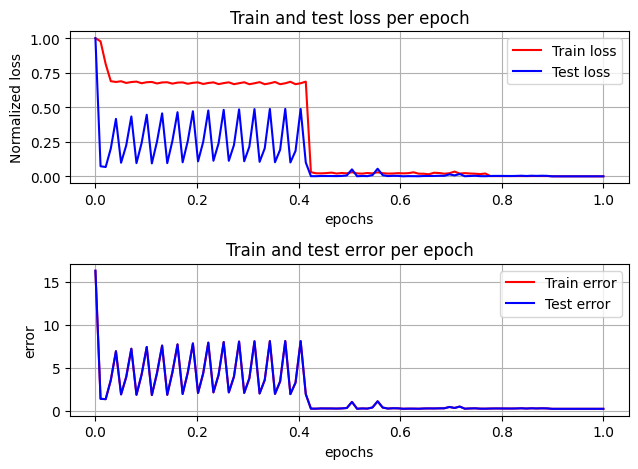

Epoch 0 | Loss train: 6.514093626976013 | Loss test: 6.788692156473796 | lr = 0.01
Epoch 10 | Loss train: 11.962617244243622 | Loss test: 14.784222837478396 | lr = 0.01
Epoch 20 | Loss train: 0.3978632432818413 | Loss test: 0.42119647680767 | lr = 0.001
Epoch 30 | Loss train: 0.35624906918406485 | Loss test: 0.28490975806637414 | lr = 0.001
Epoch 40 | Loss train: 0.41568231463432315 | Loss test: 0.3553037816096866 | lr = 0.001
Epoch 50 | Loss train: 0.272669099509716 | Loss test: 0.2574427254379742 | lr = 0.0001
Epoch 60 | Loss train: 0.2734732205271721 | Loss test: 0.2568517450302366 | lr = 0.0001
Epoch 70 | Loss train: 0.27263910868763924 | Loss test: 0.256360865892872 | lr = 0.0001
Epoch 80 | Loss train: 0.2545161011219025 | Loss test: 0.2547635826326552 | lr = 1e-05
Epoch 90 | Loss train: 0.2543631483018398 | Loss test: 0.25457053324059836 | lr = 1e-05
Epoch 100 | Loss train: 0.2542936934530735 | Loss test: 0.25443862023807706 | lr = 1e-05


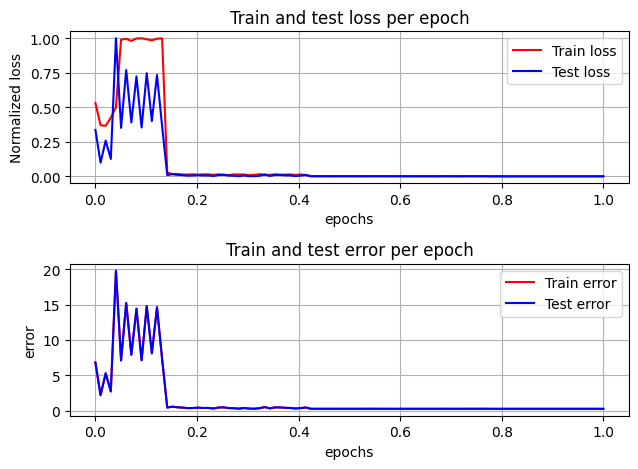

Completed CV with num splits: 5 and final error 0.2689089387655258


In [ ]:
loss_fn = nn.MSELoss()
optimizer_params = {'lr':1e-2,'momentum':0.9}
scheduler_params = {'mode':'min','factor':0.1,"patience":10}
num_splits = 5
model_params = {'input_size': input_len, 'output_size': output_len}
errors = cv_NN(model_class=SimpleModel,model_params=model_params,X=X,y=y,splits=num_splits,loss_fn=loss_fn,optimizer_class=torch.optim.SGD,optimizer_params=optimizer_params,scheduler_class=lr_scheduler.ReduceLROnPlateau,scheduler_params=scheduler_params,device=device)
print(f"Completed CV with num splits: {num_splits} and final error {np.mean(errors)}")

Έχοντας προπονήσει τα μοντέλα για 100 εποχές με διαφορετικούς optimizers παρατηρούμε ότι η καλύτερη απόδοση έιναι από τον ``` Adam ``` ο οποίος θα χρησιμοποιηθεί και μετέπειτα.

***

### Αρχιτεκτονική 2

#### ReLU 128

Το δεύτερο μοντέλο μας θα αποκτήσει άλλα 2 layers δίνοντας μας την δυνατότητα θεωρητικά να πετύχουμε μικρότερη απώλεια συγκριτικά με την απλούστερη περίπτωση. Επιπλέον μας δίνεται η δυνατότητα να μεταβάλλουμε τόσο την μεταβλητή ```hidden_units``` που καθορίζει το μέγεθος των ενδιάμεσων επιπέδων, όσο και τις συναρτήσεις ενεργοποίησης.

Για αρχή επιλέγουμε την συνηθέστερη επιλογή την συνάρτηση ``` ReLU```, ο τύπος της οποίας δίνεται παρακάτω.

$ReLU(x) = max(0,x)$

In [ ]:
# Build the model

class ReLUModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_units = 128):
        super(ReLUModel, self).__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(in_features= input_size, out_features= hidden_units),
            nn.ReLU(),
            nn.Linear(in_features= hidden_units, out_features= hidden_units),
            nn.ReLU(),
            nn.Linear(in_features= hidden_units, out_features= output_size),   
        )
    
    def forward(self, x):
        return self.linear_stack(x)

Epoch 0 | Loss train: 26.052138117313383 | Loss test: 0.1883798994951778 | lr = 0.01
Epoch 10 | Loss train: 0.0626404226385057 | Loss test: 0.06379381514021329 | lr = 0.01
Epoch 20 | Loss train: 0.03899844940751791 | Loss test: 0.03780961021899231 | lr = 0.01
Epoch 30 | Loss train: 0.037109991252422335 | Loss test: 0.03192943198576806 | lr = 0.01
Epoch 40 | Loss train: 0.014924173982813954 | Loss test: 0.01384616270661354 | lr = 0.001
Epoch 50 | Loss train: 0.013579078387469053 | Loss test: 0.011965670149832491 | lr = 0.001
Epoch 60 | Loss train: 0.013285454662516714 | Loss test: 0.012578188848223478 | lr = 0.001
Epoch 70 | Loss train: 0.013057251196354628 | Loss test: 0.012342456447344923 | lr = 0.001
Epoch 80 | Loss train: 0.012801845809444785 | Loss test: 0.012054902700973409 | lr = 0.001
Epoch 90 | Loss train: 0.012632993176579475 | Loss test: 0.011946881943870159 | lr = 0.001
Epoch 100 | Loss train: 0.012555913219228387 | Loss test: 0.012003607826218718 | lr = 0.001


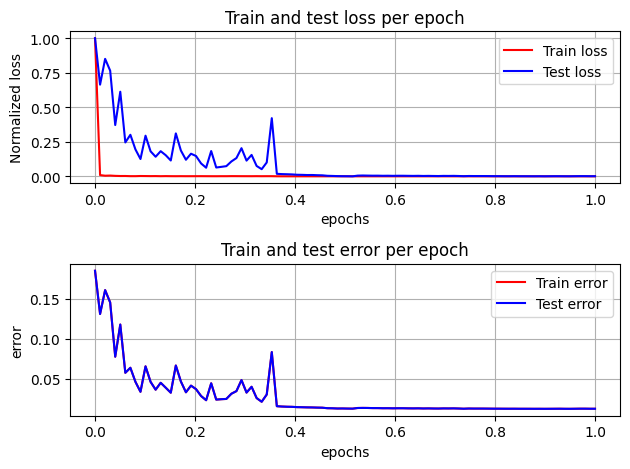

Epoch 0 | Loss train: 21.104341170549393 | Loss test: 0.4629063109556834 | lr = 0.01
Epoch 10 | Loss train: 0.05172787591814995 | Loss test: 0.06009695542946694 | lr = 0.01
Epoch 20 | Loss train: 0.03524502835422754 | Loss test: 0.08807333984545299 | lr = 0.01
Epoch 30 | Loss train: 0.03232881435751915 | Loss test: 0.04460013915030729 | lr = 0.01
Epoch 40 | Loss train: 0.03712002805992961 | Loss test: 0.024562205882772567 | lr = 0.01
Epoch 50 | Loss train: 0.028284465502947567 | Loss test: 0.020175813579015316 | lr = 0.01
Epoch 60 | Loss train: 0.03451819241046906 | Loss test: 0.023906587016960933 | lr = 0.01
Epoch 70 | Loss train: 0.012404704371467233 | Loss test: 0.011952863089622014 | lr = 0.001
Epoch 80 | Loss train: 0.011758712571114301 | Loss test: 0.011896500681778268 | lr = 0.001
Epoch 90 | Loss train: 0.011433893378823995 | Loss test: 0.011632546752927795 | lr = 0.001
Epoch 100 | Loss train: 0.011319078790023923 | Loss test: 0.011525126987151683 | lr = 0.001


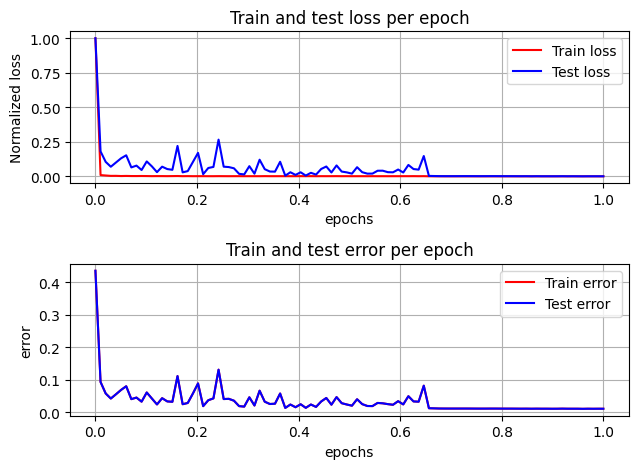

Epoch 0 | Loss train: 21.034622323036192 | Loss test: 0.16997654901610482 | lr = 0.01
Epoch 10 | Loss train: 0.05128938847035169 | Loss test: 0.07278414035127276 | lr = 0.01
Epoch 20 | Loss train: 0.05356820297241211 | Loss test: 0.036881649452779025 | lr = 0.01
Epoch 30 | Loss train: 0.0383036857098341 | Loss test: 0.04087982175960427 | lr = 0.01
Epoch 40 | Loss train: 0.048213397674262526 | Loss test: 0.03557013327048884 | lr = 0.01
Epoch 50 | Loss train: 0.031220597539097072 | Loss test: 0.02770104921526379 | lr = 0.01
Epoch 60 | Loss train: 0.012886695701628923 | Loss test: 0.013260532318363114 | lr = 0.001
Epoch 70 | Loss train: 0.010814737135544419 | Loss test: 0.010597007630008554 | lr = 0.001
Epoch 80 | Loss train: 0.010570993509143591 | Loss test: 0.010290096927848127 | lr = 0.001
Epoch 90 | Loss train: 0.010322295119985938 | Loss test: 0.01051987111124964 | lr = 0.001
Epoch 100 | Loss train: 0.01044189850986004 | Loss test: 0.010127300729176827 | lr = 0.001


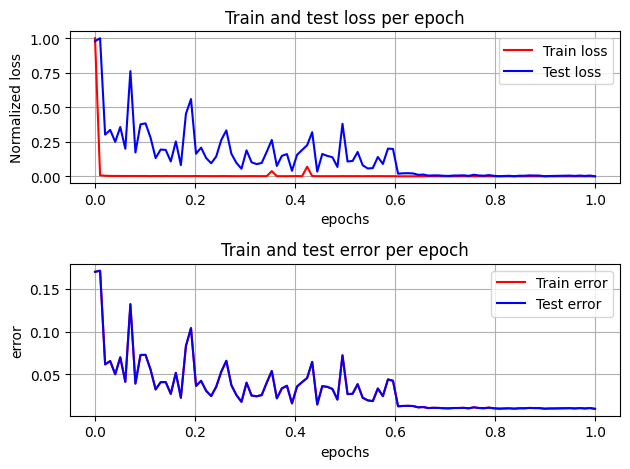

Epoch 0 | Loss train: 21.042692622780798 | Loss test: 0.15437481989936222 | lr = 0.01
Epoch 10 | Loss train: 0.04455554055050016 | Loss test: 0.11730510209287916 | lr = 0.01
Epoch 20 | Loss train: 0.03407507698237896 | Loss test: 0.03663610573858023 | lr = 0.01
Epoch 30 | Loss train: 0.03088360662013292 | Loss test: 0.01918706830058779 | lr = 0.01
Epoch 40 | Loss train: 0.012238897599279881 | Loss test: 0.011049489202421336 | lr = 0.001
Epoch 50 | Loss train: 0.012020501848310232 | Loss test: 0.010738538001619634 | lr = 0.001
Epoch 60 | Loss train: 0.01135712693631649 | Loss test: 0.010375548028461044 | lr = 0.001
Epoch 70 | Loss train: 0.011057160872966052 | Loss test: 0.009872565149433084 | lr = 0.001
Epoch 80 | Loss train: 0.010827168006449938 | Loss test: 0.009749867162475037 | lr = 0.001
Epoch 90 | Loss train: 0.010714640652760864 | Loss test: 0.009715256916861686 | lr = 0.001
Epoch 100 | Loss train: 0.010546371191740036 | Loss test: 0.00939027526755891 | lr = 0.001


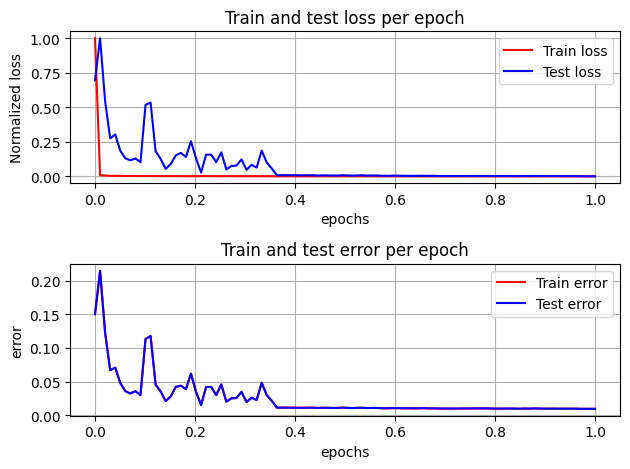

Epoch 0 | Loss train: 21.047646309047938 | Loss test: 0.2829475322413066 | lr = 0.01
Epoch 10 | Loss train: 0.043892583832144734 | Loss test: 0.021814119203814437 | lr = 0.01
Epoch 20 | Loss train: 0.038083798587322235 | Loss test: 0.03724438419181203 | lr = 0.01
Epoch 30 | Loss train: 0.03236799028143287 | Loss test: 0.03871211173042419 | lr = 0.01
Epoch 40 | Loss train: 0.013845899915322661 | Loss test: 0.014794704873883536 | lr = 0.001
Epoch 50 | Loss train: 0.01324389242194593 | Loss test: 0.014014289359606448 | lr = 0.001
Epoch 60 | Loss train: 0.011996075978502631 | Loss test: 0.012232376026019218 | lr = 0.001
Epoch 70 | Loss train: 0.011047358870506287 | Loss test: 0.0107415004352492 | lr = 0.001
Epoch 80 | Loss train: 0.010858437210321427 | Loss test: 0.01096631789816514 | lr = 0.001
Epoch 90 | Loss train: 0.01070581560768187 | Loss test: 0.010627687960449193 | lr = 0.001
Epoch 100 | Loss train: 0.010615595864132047 | Loss test: 0.010812303243530176 | lr = 0.001


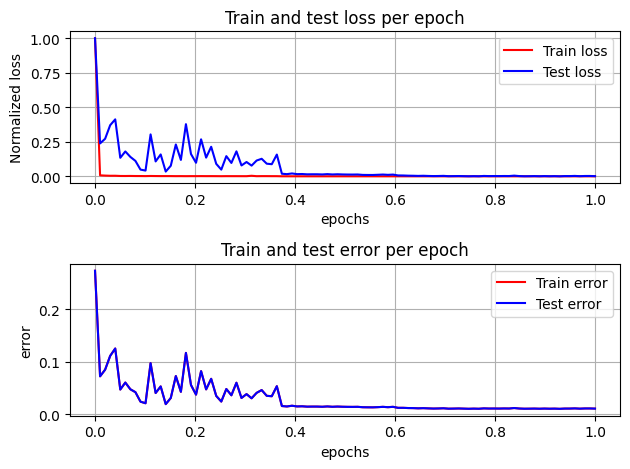

Completed CV with num splits: 5 and final error 0.01071331612765789
Epoch 0 | Loss train: 16.844663220924883 | lr = 0.01
Epoch 10 | Loss train: 0.04103103258941596 | lr = 0.01
Epoch 20 | Loss train: 0.04121636695707568 | lr = 0.01
Epoch 30 | Loss train: 0.040421705270489564 | lr = 0.01
Epoch 40 | Loss train: 0.013681112672574222 | lr = 0.001
Epoch 50 | Loss train: 0.013274897363024969 | lr = 0.001
Epoch 60 | Loss train: 0.012512640460742453 | lr = 0.001
Epoch 70 | Loss train: 0.012328118462258349 | lr = 0.001
Epoch 80 | Loss train: 0.01246406296535898 | lr = 0.001
Epoch 90 | Loss train: 0.012156686959817958 | lr = 0.001
Epoch 100 | Loss train: 0.012114108374979074 | lr = 0.001


In [ ]:
loss_fn = nn.MSELoss()
optimizer_params = {'lr':1e-2}
scheduler_params = {'mode':'min','factor':0.1,"patience":10}
num_splits = 5
model_params = {'input_size': input_len, 'output_size': output_len}
errors = cv_NN(model_class=ReLUModel,model_params=model_params,X=X,y=y,splits=num_splits,loss_fn=loss_fn,optimizer_class=torch.optim.Adam,optimizer_params=optimizer_params,scheduler_class=lr_scheduler.ReduceLROnPlateau,scheduler_params=scheduler_params,device=device)
print(f"Completed CV with num splits: {num_splits} and final error {np.mean(errors)}")
relu_model_loss = np.mean(errors)
# Instantiate the model
model_3 = ReLUModel(input_size=input_len, output_size=output_len)



loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_3.parameters(), **optimizer_params)

# Initialize the scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, **scheduler_params)

train_loss, train_err = train_test_model(epoch = 100,model = model_3, train_loader= train_whole_dataloader, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler, device=device,test=False)

save_model_info(model_3,os.path.join(new_folder_path,"relu_model"))

Ήδη τα αποτελέσματα είναι πολύ καλύτερα συγκριτικά με την προηγούμενη αρχιτεκτονική.

#### ReLU 256

Τώρα θα αυξήσουμε τον αριθμό των ```hidden_units```  από 128 σε 256 για να δούμε κάποια πιθανή διαφορά.

Epoch 0 | Loss train: 148.12494586241246 | Loss test: 0.5444374566986447 | lr = 0.01
Epoch 10 | Loss train: 0.45677318978309633 | Loss test: 0.2922130513285834 | lr = 0.01
Epoch 20 | Loss train: 0.1256361516714096 | Loss test: 0.13148003047893916 | lr = 0.01
Epoch 30 | Loss train: 0.09537768927216529 | Loss test: 0.08534874471407088 | lr = 0.01
Epoch 40 | Loss train: 0.04884045565128326 | Loss test: 0.09533317410756671 | lr = 0.01
Epoch 50 | Loss train: 0.0536636067405343 | Loss test: 0.062184728918567536 | lr = 0.01
Epoch 60 | Loss train: 0.026526609648019076 | Loss test: 0.02656751683366204 | lr = 0.001
Epoch 70 | Loss train: 0.02331542461179197 | Loss test: 0.021789036454662444 | lr = 0.001
Epoch 80 | Loss train: 0.02125422042608261 | Loss test: 0.019699686472969397 | lr = 0.001
Epoch 90 | Loss train: 0.02019892739504576 | Loss test: 0.018553976486954425 | lr = 0.001
Epoch 100 | Loss train: 0.019218787947669624 | Loss test: 0.01778882907496558 | lr = 0.001


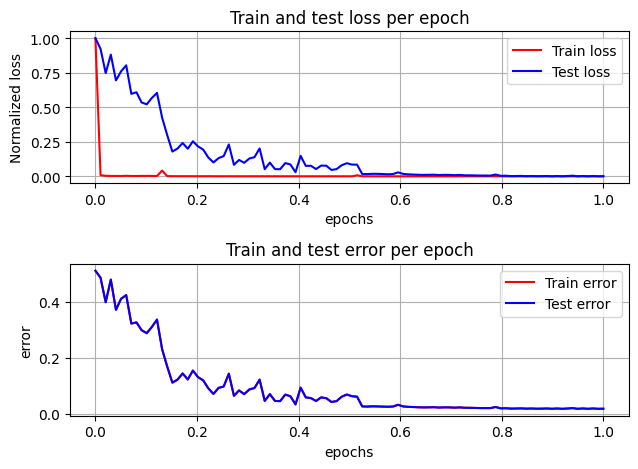

Epoch 0 | Loss train: 92.58702561271191 | Loss test: 0.11752439680553618 | lr = 0.01
Epoch 10 | Loss train: 0.060486106470227244 | Loss test: 0.07449713508997645 | lr = 0.01
Epoch 20 | Loss train: 0.04414604540914297 | Loss test: 0.10291551952324217 | lr = 0.01
Epoch 30 | Loss train: 0.04105756806582212 | Loss test: 0.022193037150871186 | lr = 0.01
Epoch 40 | Loss train: 0.01429995258897543 | Loss test: 0.01360471486040051 | lr = 0.001
Epoch 50 | Loss train: 0.012816914577037096 | Loss test: 0.012357587630431804 | lr = 0.001
Epoch 60 | Loss train: 0.012915897570550441 | Loss test: 0.012018644945725562 | lr = 0.001
Epoch 70 | Loss train: 0.012714678971096873 | Loss test: 0.012066449334342328 | lr = 0.001
Epoch 80 | Loss train: 0.012970012536272406 | Loss test: 0.011438000599838911 | lr = 0.001
Epoch 90 | Loss train: 0.012764742569997907 | Loss test: 0.012472633457195664 | lr = 0.001
Epoch 100 | Loss train: 0.012736943962052464 | Loss test: 0.012468838605970617 | lr = 0.001


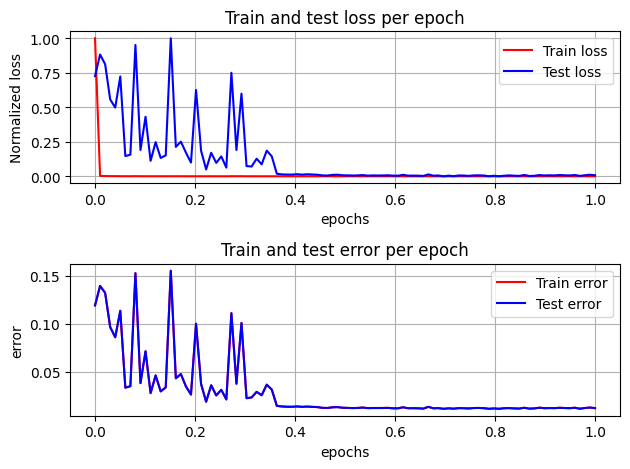

Epoch 0 | Loss train: 92.56781420466304 | Loss test: 0.10320636511795105 | lr = 0.01
Epoch 10 | Loss train: 0.05692985130846501 | Loss test: 0.07854903406567043 | lr = 0.01
Epoch 20 | Loss train: 0.044165646646171806 | Loss test: 0.06340500582305211 | lr = 0.01
Epoch 30 | Loss train: 0.015775599651038648 | Loss test: 0.015819981915964967 | lr = 0.001
Epoch 40 | Loss train: 0.013782604806125164 | Loss test: 0.015740735131123708 | lr = 0.001
Epoch 50 | Loss train: 0.013174859115853905 | Loss test: 0.014091435036370678 | lr = 0.001
Epoch 60 | Loss train: 0.013179050276055933 | Loss test: 0.013496153987944126 | lr = 0.001
Epoch 70 | Loss train: 0.012589269196614622 | Loss test: 0.012902185483466066 | lr = 0.001
Epoch 80 | Loss train: 0.012370281843468547 | Loss test: 0.013249311322671554 | lr = 0.001
Epoch 90 | Loss train: 0.01204975951090455 | Loss test: 0.012508254202585372 | lr = 0.001
Epoch 100 | Loss train: 0.011386325780302286 | Loss test: 0.012041847169813182 | lr = 0.001


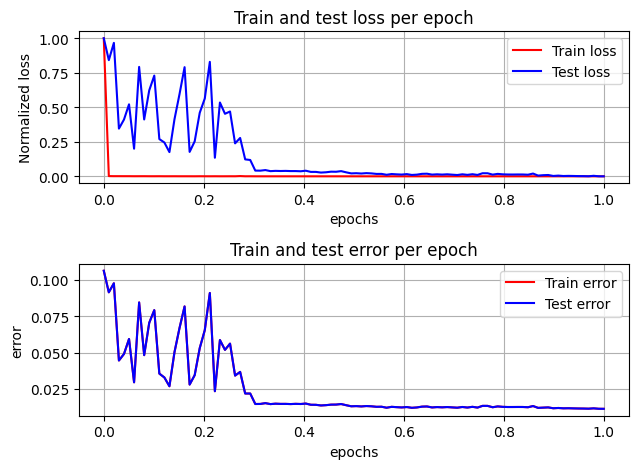

Epoch 0 | Loss train: 92.62714998444915 | Loss test: 0.1919128511633192 | lr = 0.01
Epoch 10 | Loss train: 0.11223080835491418 | Loss test: 0.075729843288187 | lr = 0.01
Epoch 20 | Loss train: 0.03925459305569529 | Loss test: 0.03575884810988865 | lr = 0.01
Epoch 30 | Loss train: 0.035448284819722176 | Loss test: 0.0671135995477911 | lr = 0.01
Epoch 40 | Loss train: 0.03796884972602129 | Loss test: 0.03674460767162225 | lr = 0.01
Epoch 50 | Loss train: 0.012808465957641601 | Loss test: 0.01285064449563386 | lr = 0.001
Epoch 60 | Loss train: 0.011963546434417367 | Loss test: 0.013055464119783469 | lr = 0.001
Epoch 70 | Loss train: 0.011311579417437314 | Loss test: 0.011619948737678073 | lr = 0.001
Epoch 80 | Loss train: 0.011056846246123313 | Loss test: 0.011554336633592371 | lr = 0.001
Epoch 90 | Loss train: 0.011065346853807568 | Loss test: 0.011804825921971646 | lr = 0.001
Epoch 100 | Loss train: 0.010908005706965923 | Loss test: 0.011276096083401214 | lr = 0.001


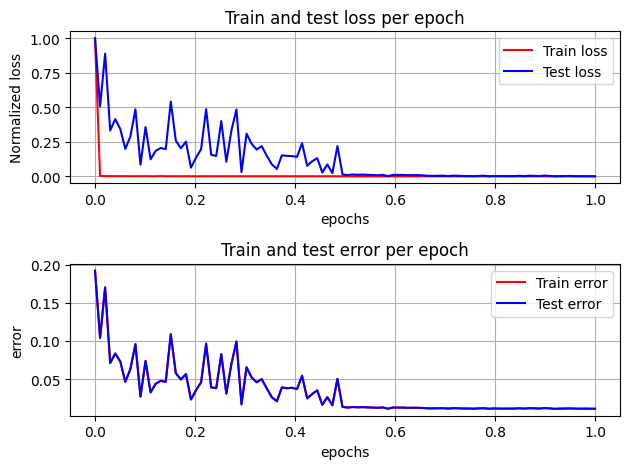

Epoch 0 | Loss train: 92.59251423099637 | Loss test: 0.16142429139405962 | lr = 0.01
Epoch 10 | Loss train: 0.04975165730714798 | Loss test: 0.06164085959631299 | lr = 0.01
Epoch 20 | Loss train: 0.03526681775227189 | Loss test: 0.06251700263884333 | lr = 0.01
Epoch 30 | Loss train: 0.03408476494252682 | Loss test: 0.020184081550391895 | lr = 0.01
Epoch 40 | Loss train: 0.033631341107189655 | Loss test: 0.020763262337635435 | lr = 0.01
Epoch 50 | Loss train: 0.028151166893541812 | Loss test: 0.038291806295987156 | lr = 0.01
Epoch 60 | Loss train: 0.0166188927590847 | Loss test: 0.016407091806214007 | lr = 0.001
Epoch 70 | Loss train: 0.01588646775111556 | Loss test: 0.016451142003966704 | lr = 0.001
Epoch 80 | Loss train: 0.015924067659303546 | Loss test: 0.016100704485166168 | lr = 0.001
Epoch 90 | Loss train: 0.015843580717220904 | Loss test: 0.015623272404015537 | lr = 0.001
Epoch 100 | Loss train: 0.01567583741247654 | Loss test: 0.015514606432545753 | lr = 0.001


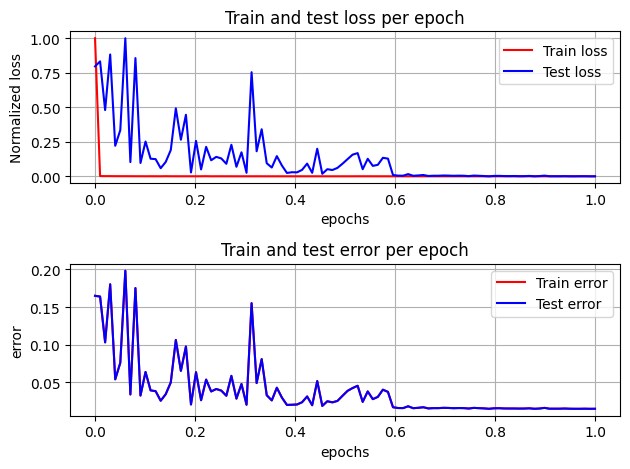

Completed CV with num splits: 5 and final error 0.013620735704898834
Epoch 0 | Loss train: 74.03119569257521 | lr = 0.01
Epoch 10 | Loss train: 0.06275504451994889 | lr = 0.01
Epoch 20 | Loss train: 0.039905038635475565 | lr = 0.01
Epoch 30 | Loss train: 0.04277799978923683 | lr = 0.001
Epoch 40 | Loss train: 0.015384199581266687 | lr = 0.001
Epoch 50 | Loss train: 0.015233648226807674 | lr = 0.001
Epoch 60 | Loss train: 0.012945945300280858 | lr = 0.001
Epoch 70 | Loss train: 0.012825937877697782 | lr = 0.001
Epoch 80 | Loss train: 0.012550757724803668 | lr = 0.001
Epoch 90 | Loss train: 0.012382759223171412 | lr = 0.001
Epoch 100 | Loss train: 0.012275247830159652 | lr = 0.001


In [ ]:
loss_fn = nn.MSELoss()
optimizer_params = {'lr':1e-2}
scheduler_params = {'mode':'min','factor':0.1,"patience":10}
model_params = {'input_size':input_len, 'output_size':output_len, 'hidden_units':256}
num_splits = 5
errors = cv_NN(model_class=ReLUModel,model_params=model_params,X=X,y=y,splits=num_splits,loss_fn=loss_fn,optimizer_class=torch.optim.Adam,optimizer_params=optimizer_params,scheduler_class=lr_scheduler.ReduceLROnPlateau,scheduler_params=scheduler_params,device=device)
print(f"Completed CV with num splits: {num_splits} and final error {np.mean(errors)}")
relu_model_256_loss = np.mean(errors)
# Instantiate the model
model_4 = ReLUModel(**model_params)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_4.parameters(), **optimizer_params)

# Initialize the scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, **scheduler_params)

train_loss, train_err = train_test_model(epoch = 100,model = model_4, train_loader= train_whole_dataloader, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler, device=device,test=False)

save_model_info(model_4,os.path.join(new_folder_path,"relu_model_256"))

#### ReLU 64

Τα αποτελέσματα με 128 hidden units είναι καλύτερα, δοκιμάζουμε τέλος με 64.

Epoch 0 | Loss train: 9.13746812993288 | Loss test: 0.3651209570585735 | lr = 0.01
Epoch 10 | Loss train: 0.03735031487047672 | Loss test: 0.04022198445385411 | lr = 0.01
Epoch 20 | Loss train: 0.029433952402323483 | Loss test: 0.012597633643992363 | lr = 0.01
Epoch 30 | Loss train: 0.028969944782555105 | Loss test: 0.01963701190811301 | lr = 0.01
Epoch 40 | Loss train: 0.009849524145945907 | Loss test: 0.008534254772322518 | lr = 0.001
Epoch 50 | Loss train: 0.0082393965004012 | Loss test: 0.007685384180928979 | lr = 0.001
Epoch 60 | Loss train: 0.007971282942220569 | Loss test: 0.0075321015901863575 | lr = 0.001
Epoch 70 | Loss train: 0.007821330573409795 | Loss test: 0.007561445583604158 | lr = 0.001
Epoch 80 | Loss train: 0.007773184866644442 | Loss test: 0.007355906032321472 | lr = 0.001
Epoch 90 | Loss train: 0.007707219585776329 | Loss test: 0.007164841310845481 | lr = 0.001
Epoch 100 | Loss train: 0.006532816227525473 | Loss test: 0.006422871701596748 | lr = 0.0001


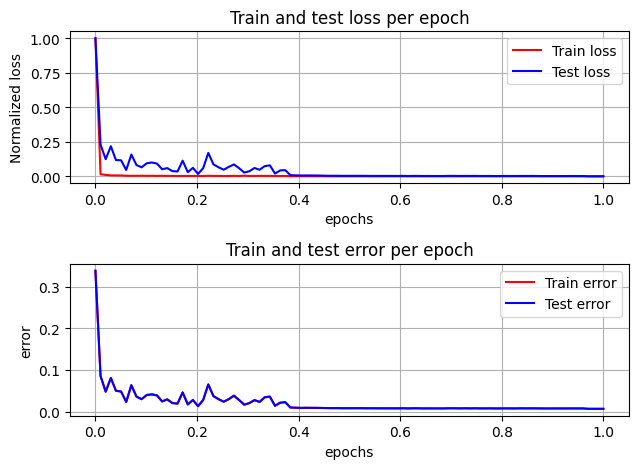

Epoch 0 | Loss train: 3.761722200080752 | Loss test: 0.22369578007667784 | lr = 0.01
Epoch 10 | Loss train: 0.04277831294760108 | Loss test: 0.03138316898710198 | lr = 0.01
Epoch 20 | Loss train: 0.036632113680243494 | Loss test: 0.03365910221778211 | lr = 0.01
Epoch 30 | Loss train: 0.030388438902795314 | Loss test: 0.0203689822542762 | lr = 0.01
Epoch 40 | Loss train: 0.009381393643096089 | Loss test: 0.009624705908613073 | lr = 0.001
Epoch 50 | Loss train: 0.009000606775283814 | Loss test: 0.008937244066998126 | lr = 0.001
Epoch 60 | Loss train: 0.008819913800805807 | Loss test: 0.008759102392350398 | lr = 0.001
Epoch 70 | Loss train: 0.00873599455319345 | Loss test: 0.00874402059153432 | lr = 0.001
Epoch 80 | Loss train: 0.008686901843175292 | Loss test: 0.008709371237764283 | lr = 0.001
Epoch 90 | Loss train: 0.008632907750084996 | Loss test: 0.00862134023318215 | lr = 0.001
Epoch 100 | Loss train: 0.008589794008061289 | Loss test: 0.00852891986095716 | lr = 0.001


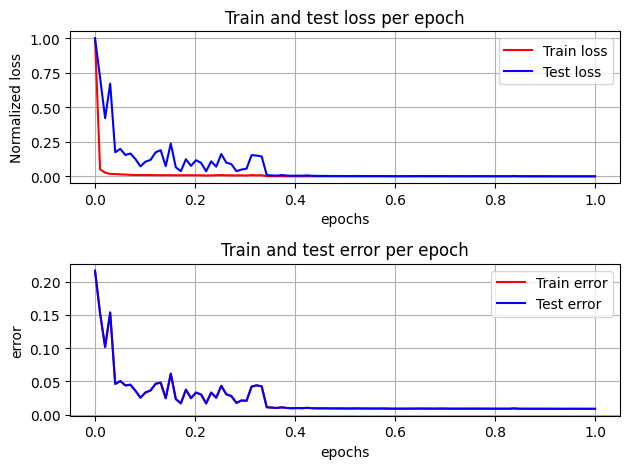

Epoch 0 | Loss train: 3.79877037204802 | Loss test: 0.687527638106119 | lr = 0.01
Epoch 10 | Loss train: 0.056634710103273395 | Loss test: 0.027843623111645382 | lr = 0.01
Epoch 20 | Loss train: 0.03412069387733936 | Loss test: 0.01803483110335138 | lr = 0.01
Epoch 30 | Loss train: 0.0563037529066205 | Loss test: 0.0235508167377067 | lr = 0.01
Epoch 40 | Loss train: 0.011981559224426746 | Loss test: 0.011913611087948084 | lr = 0.001
Epoch 50 | Loss train: 0.011753654340282083 | Loss test: 0.011494215060439374 | lr = 0.001
Epoch 60 | Loss train: 0.0110076792743057 | Loss test: 0.010768461055935376 | lr = 0.001
Epoch 70 | Loss train: 0.010561790402978659 | Loss test: 0.010576571685276807 | lr = 0.001
Epoch 80 | Loss train: 0.010575187316164374 | Loss test: 0.010120507994932788 | lr = 0.001
Epoch 90 | Loss train: 0.00906890513934195 | Loss test: 0.009515998012844532 | lr = 0.0001
Epoch 100 | Loss train: 0.009056435633450747 | Loss test: 0.009495047933702904 | lr = 0.0001


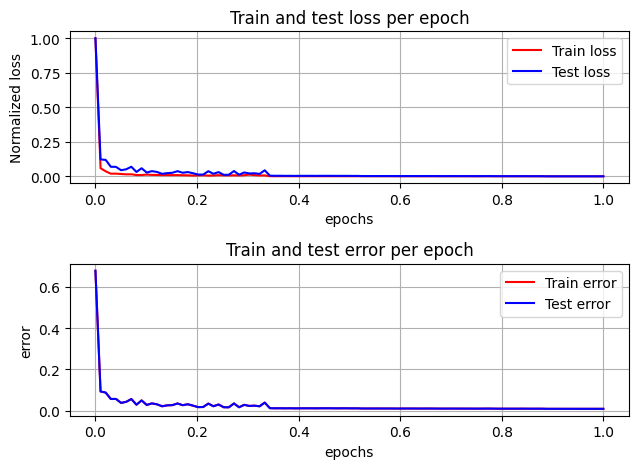

Epoch 0 | Loss train: 3.7184824019372464 | Loss test: 0.16026070512949475 | lr = 0.01
Epoch 10 | Loss train: 0.05051997445523739 | Loss test: 0.14416607090878109 | lr = 0.01
Epoch 20 | Loss train: 0.04065490129962564 | Loss test: 0.019401854658055873 | lr = 0.01
Epoch 30 | Loss train: 0.03511832917481661 | Loss test: 0.03462783285667972 | lr = 0.01
Epoch 40 | Loss train: 0.016766920272260906 | Loss test: 0.01519753820898514 | lr = 0.001
Epoch 50 | Loss train: 0.013550248308107258 | Loss test: 0.013374897340933481 | lr = 0.001
Epoch 60 | Loss train: 0.012997145656496286 | Loss test: 0.012477807168449675 | lr = 0.001
Epoch 70 | Loss train: 0.012778957460075617 | Loss test: 0.012079046447835272 | lr = 0.001
Epoch 80 | Loss train: 0.011090142507106066 | Loss test: 0.010915646743443277 | lr = 0.0001
Epoch 90 | Loss train: 0.010935040144249796 | Loss test: 0.010811767267388485 | lr = 0.0001
Epoch 100 | Loss train: 0.0109143634904176 | Loss test: 0.010785896708035753 | lr = 0.0001


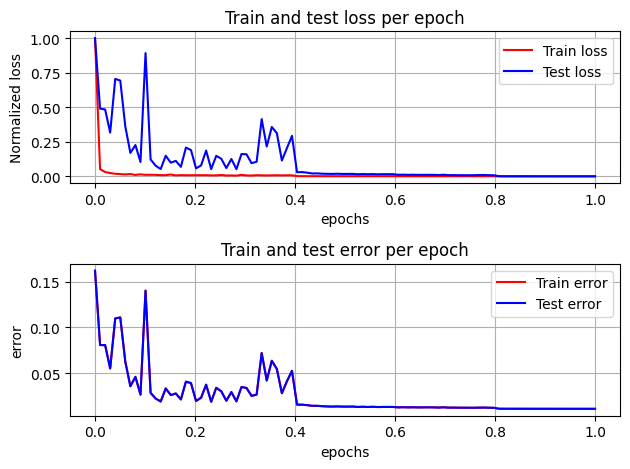

Epoch 0 | Loss train: 3.7235295954346657 | Loss test: 0.3231659377851183 | lr = 0.01
Epoch 10 | Loss train: 0.05895488173514605 | Loss test: 0.06720460679322954 | lr = 0.01
Epoch 20 | Loss train: 0.03790694922208786 | Loss test: 0.021050630551245477 | lr = 0.01
Epoch 30 | Loss train: 0.03264485217630863 | Loss test: 0.03766940409938494 | lr = 0.01
Epoch 40 | Loss train: 0.053236853666603565 | Loss test: 0.04037599168008282 | lr = 0.01
Epoch 50 | Loss train: 0.015624450698494911 | Loss test: 0.016179637761697882 | lr = 0.001
Epoch 60 | Loss train: 0.014016022149473428 | Loss test: 0.01381564824768002 | lr = 0.001
Epoch 70 | Loss train: 0.014025249293074011 | Loss test: 0.013348159114164966 | lr = 0.001
Epoch 80 | Loss train: 0.012112494828179478 | Loss test: 0.012249209119805269 | lr = 0.0001
Epoch 90 | Loss train: 0.012085819117724895 | Loss test: 0.012228725677622216 | lr = 0.0001
Epoch 100 | Loss train: 0.012065997563302518 | Loss test: 0.012209392951003142 | lr = 0.0001


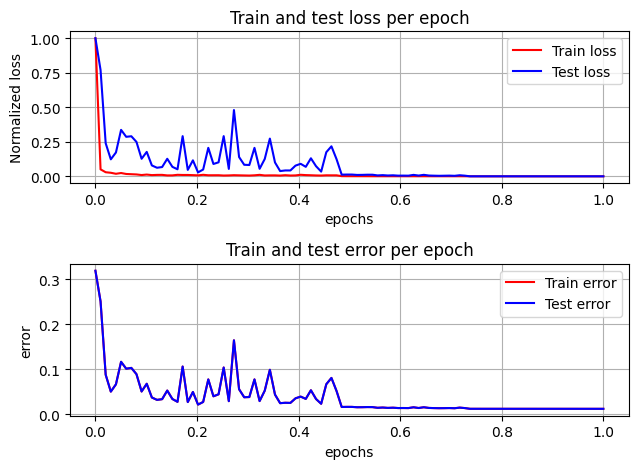

Completed CV with num splits: 5 and final error 0.009428187739104033
Epoch 0 | Loss train: 3.0134845963253762 | lr = 0.01
Epoch 10 | Loss train: 0.04034765433377256 | lr = 0.01
Epoch 20 | Loss train: 0.042841827601027754 | lr = 0.01
Epoch 30 | Loss train: 0.03440313090603001 | lr = 0.01
Epoch 40 | Loss train: 0.012269931965873549 | lr = 0.001
Epoch 50 | Loss train: 0.012218376514486992 | lr = 0.001
Epoch 60 | Loss train: 0.011866465684014577 | lr = 0.001
Epoch 70 | Loss train: 0.011910736130865903 | lr = 0.001
Epoch 80 | Loss train: 0.010032692284415515 | lr = 0.0001
Epoch 90 | Loss train: 0.010011626986233285 | lr = 0.0001
Epoch 100 | Loss train: 0.00999489161052024 | lr = 0.0001


In [ ]:
loss_fn = nn.MSELoss()
optimizer_params = {'lr':1e-2}
scheduler_params = {'mode':'min','factor':0.1,"patience":10}
model_params = {'input_size':input_len, 'output_size':output_len, 'hidden_units':64}
num_splits = 5
errors = cv_NN(model_class=ReLUModel,model_params=model_params,X=X,y=y,splits=num_splits,loss_fn=loss_fn,optimizer_class=torch.optim.Adam,optimizer_params=optimizer_params,scheduler_class=lr_scheduler.ReduceLROnPlateau,scheduler_params=scheduler_params,device=device)
print(f"Completed CV with num splits: {num_splits} and final error {np.mean(errors)}")
relu_model_64_loss = np.mean(errors)
# Instantiate the model
model_5 = ReLUModel(**model_params)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_5.parameters(), **optimizer_params)

# Initialize the scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, **scheduler_params)

train_loss, train_err = train_test_model(epoch = 100,model = model_5, train_loader= train_whole_dataloader, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler, device=device,test=False)

save_model_info(model_5,os.path.join(new_folder_path,"relu_model_64"))

Η καλύτερη περίπτωση φαίνεται να είναι με 64 ```hidden_units```, αλλά για την ώρα κρατάμε τα 128

***

### Αρχιτεκτονική 2.1

#### LeakyRELU

Για την συγκεκριμένη αρχιτεκτονική και τα συγκεκριμένα ```hidden_units``` θα μελετήσουμε την διαφορά που προκαλούν διάφορες συναρτήσεις ενεργοποίησης.

Αρχικά μελετάμε την LeakyReLU, με τύπο:

$LeakyReLU(x) = max(0,x) + negative\_slope * min(0,x)$

In [ ]:
class LeakyReLUModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_units = 128):
        super(LeakyReLUModel, self).__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(in_features= input_size, out_features= hidden_units),
            nn.LeakyReLU(0.1),
            nn.Linear(in_features= hidden_units, out_features= hidden_units),
            nn.LeakyReLU(0.1),
            nn.Linear(in_features= hidden_units, out_features= output_size),   
        )
    
    def forward(self, x):
        return self.linear_stack(x)

Epoch 0 | Loss train: 66.72602553445101 | Loss test: 0.34021363206326016 | lr = 0.01
Epoch 10 | Loss train: 0.5105706548094749 | Loss test: 0.3110374306875562 | lr = 0.01
Epoch 20 | Loss train: 0.013782625680789352 | Loss test: 0.020798529882634444 | lr = 0.001
Epoch 30 | Loss train: 0.008533946237992496 | Loss test: 0.014074488565148343 | lr = 0.001
Epoch 40 | Loss train: 0.0067066573118790985 | Loss test: 0.007073187402316502 | lr = 0.001
Epoch 50 | Loss train: 0.00656675552111119 | Loss test: 0.0062791268629509775 | lr = 0.001
Epoch 60 | Loss train: 0.00669457493443042 | Loss test: 0.00617403940608104 | lr = 0.001
Epoch 70 | Loss train: 0.008246865899302066 | Loss test: 0.006100241220482285 | lr = 0.001
Epoch 80 | Loss train: 0.005777672781143338 | Loss test: 0.005569879324101503 | lr = 0.001
Epoch 90 | Loss train: 0.006366742892190814 | Loss test: 0.005873596465717706 | lr = 0.001
Epoch 100 | Loss train: 0.005726973611395806 | Loss test: 0.005230725391782702 | lr = 0.001


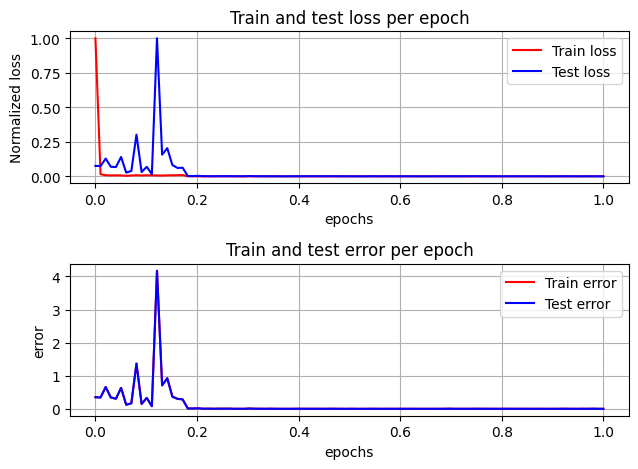

Epoch 0 | Loss train: 21.182905649393795 | Loss test: 0.3035666403316316 | lr = 0.01
Epoch 10 | Loss train: 0.41612103885412216 | Loss test: 0.9493320715569314 | lr = 0.01
Epoch 20 | Loss train: 0.011175346672534942 | Loss test: 0.006881109420357952 | lr = 0.001
Epoch 30 | Loss train: 0.009555608591996133 | Loss test: 0.0068972004680997795 | lr = 0.001
Epoch 40 | Loss train: 0.007686901503242552 | Loss test: 0.005735051234267534 | lr = 0.001
Epoch 50 | Loss train: 0.007827466305345298 | Loss test: 0.007827786063509328 | lr = 0.001
Epoch 60 | Loss train: 0.006725784787908196 | Loss test: 0.006060572729135553 | lr = 0.001
Epoch 70 | Loss train: 0.007609644371084869 | Loss test: 0.00617215358134773 | lr = 0.001
Epoch 80 | Loss train: 0.009341110808774828 | Loss test: 0.00525707558226136 | lr = 0.001
Epoch 90 | Loss train: 0.005991997632663697 | Loss test: 0.005591720039586699 | lr = 0.001
Epoch 100 | Loss train: 0.00728925199713558 | Loss test: 0.005271856713714817 | lr = 0.001


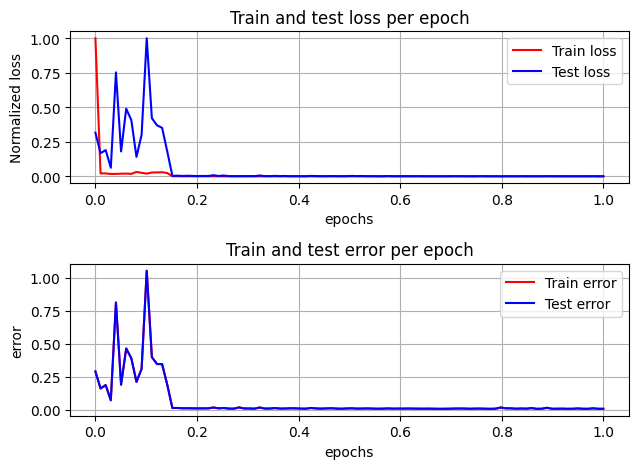

Epoch 0 | Loss train: 21.28076982396841 | Loss test: 0.48055519305524375 | lr = 0.01
Epoch 10 | Loss train: 0.4151753834486008 | Loss test: 0.11074919821251006 | lr = 0.01
Epoch 20 | Loss train: 0.011115804363042115 | Loss test: 0.013605282434986697 | lr = 0.001
Epoch 30 | Loss train: 0.007600459985435009 | Loss test: 0.009042864177553426 | lr = 0.001
Epoch 40 | Loss train: 0.006596553269773721 | Loss test: 0.01076135714168823 | lr = 0.001
Epoch 50 | Loss train: 0.006219654258340597 | Loss test: 0.0664332971117267 | lr = 0.001
Epoch 60 | Loss train: 0.0063097343752160666 | Loss test: 0.04132369091911685 | lr = 0.001
Epoch 70 | Loss train: 0.0054851634302176535 | Loss test: 0.19921341191770303 | lr = 0.001
Epoch 80 | Loss train: 0.005604752151295543 | Loss test: 0.3794359795246569 | lr = 0.001
Epoch 90 | Loss train: 0.00533450920227915 | Loss test: 0.43894740529654047 | lr = 0.001
Epoch 100 | Loss train: 0.005314512999728322 | Loss test: 1.1023289192290533 | lr = 0.001


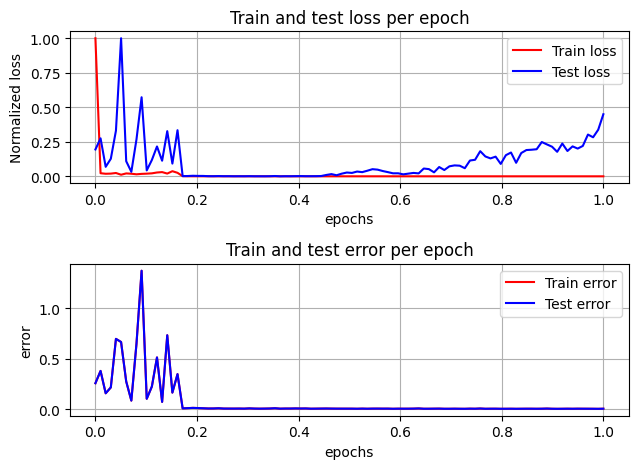

Epoch 0 | Loss train: 21.296665736973285 | Loss test: 0.34818638222558157 | lr = 0.01
Epoch 10 | Loss train: 0.49094797495007514 | Loss test: 0.24792465662199353 | lr = 0.01
Epoch 20 | Loss train: 0.012995117627084255 | Loss test: 0.007418205976367943 | lr = 0.001
Epoch 30 | Loss train: 0.008328289898112417 | Loss test: 0.009208572111905568 | lr = 0.001
Epoch 40 | Loss train: 0.007619655404239893 | Loss test: 0.0063265295521844 | lr = 0.001
Epoch 50 | Loss train: 0.006848339347168803 | Loss test: 0.005489268986922171 | lr = 0.001
Epoch 60 | Loss train: 0.00724367132037878 | Loss test: 0.005770966514117188 | lr = 0.001
Epoch 70 | Loss train: 0.006537173266522586 | Loss test: 0.005636997753754258 | lr = 0.001
Epoch 80 | Loss train: 0.00705500378459692 | Loss test: 0.00720965549615877 | lr = 0.001
Epoch 90 | Loss train: 0.005830307916738093 | Loss test: 0.006056316562795213 | lr = 0.001
Epoch 100 | Loss train: 0.006071974254213274 | Loss test: 0.00702484707451529 | lr = 0.0001


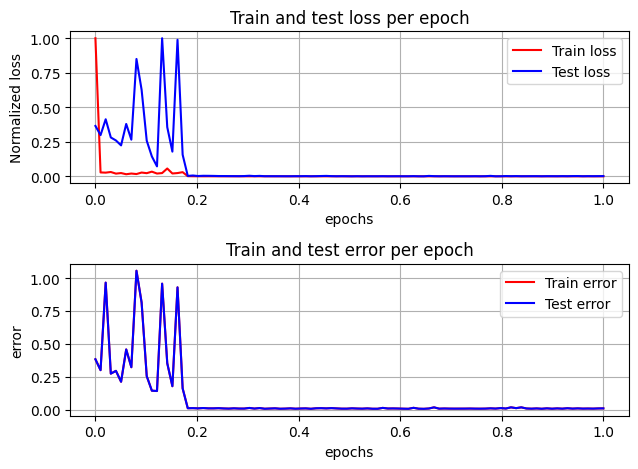

Epoch 0 | Loss train: 21.398626140892507 | Loss test: 1.5808288019800942 | lr = 0.01
Epoch 10 | Loss train: 0.8656932546198368 | Loss test: 0.6274421030566806 | lr = 0.01
Epoch 20 | Loss train: 0.013140006747096778 | Loss test: 0.006568352399866969 | lr = 0.001
Epoch 30 | Loss train: 0.008918954361230134 | Loss test: 0.00661293734678082 | lr = 0.001
Epoch 40 | Loss train: 0.00756376541685313 | Loss test: 0.007638997645930402 | lr = 0.001
Epoch 50 | Loss train: 0.007438342498615384 | Loss test: 0.0065723923515410175 | lr = 0.001
Epoch 60 | Loss train: 0.006589753054082393 | Loss test: 0.006757673482218432 | lr = 0.001
Epoch 70 | Loss train: 0.00753412525402382 | Loss test: 0.006728153838406479 | lr = 0.001
Epoch 80 | Loss train: 0.006931326384656131 | Loss test: 0.007317313358985952 | lr = 0.001
Epoch 90 | Loss train: 0.005928206199780107 | Loss test: 0.005891918319292248 | lr = 0.001
Epoch 100 | Loss train: 0.005810498405247927 | Loss test: 0.006860414708387994 | lr = 0.001


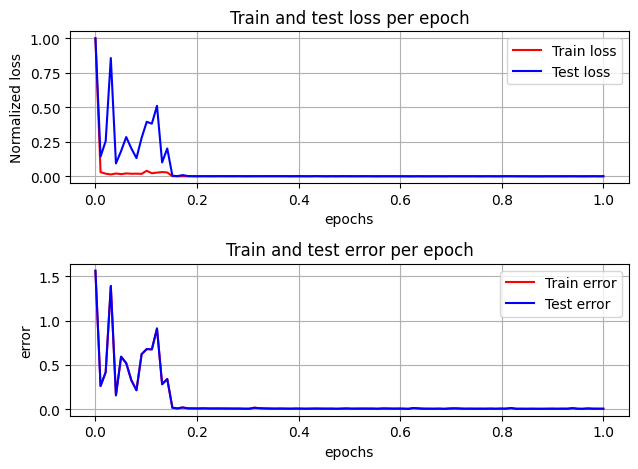

Completed CV with num splits: 5 and final error 0.006425520963966846
Epoch 0 | Loss train: 17.254259572290003 | lr = 0.01
Epoch 10 | Loss train: 0.5193192354811076 | lr = 0.01
Epoch 20 | Loss train: 0.01001504357508458 | lr = 0.001
Epoch 30 | Loss train: 0.007407210621471032 | lr = 0.001
Epoch 40 | Loss train: 0.00704471982707576 | lr = 0.001
Epoch 50 | Loss train: 0.006926108914510772 | lr = 0.001
Epoch 60 | Loss train: 0.006053733548667199 | lr = 0.001
Epoch 70 | Loss train: 0.00624570910693905 | lr = 0.001
Epoch 80 | Loss train: 0.005527920499533272 | lr = 0.0001
Epoch 90 | Loss train: 0.00399409609507567 | lr = 0.0001
Epoch 100 | Loss train: 0.003969124028125938 | lr = 0.0001


In [ ]:
loss_fn = nn.MSELoss()
optimizer_params = {'lr':1e-2}
scheduler_params = {'mode':'min','factor':0.1,"patience":10}
model_params = {'input_size':input_len, 'output_size':output_len}
num_splits = 5
errors = cv_NN(model_class=LeakyReLUModel,model_params=model_params,X=X,y=y,splits=num_splits,loss_fn=loss_fn,optimizer_class=torch.optim.Adam,optimizer_params=optimizer_params,scheduler_class=lr_scheduler.ReduceLROnPlateau,scheduler_params=scheduler_params,device=device)
print(f"Completed CV with num splits: {num_splits} and final error {np.mean(errors)}")
leaky_relu_loss = np.mean(errors)
# Instantiate the model
model_6 = LeakyReLUModel(**model_params)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_6.parameters(), **optimizer_params)

# Initialize the scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, **scheduler_params)

train_loss, train_err = train_test_model(epoch = 100,model = model_6, train_loader= train_whole_dataloader, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler, device=device,test=False)

save_model_info(model_6,os.path.join(new_folder_path,"relu_model_64"))

#### Tanh

Δοκιμάζουμε την συνάρτηση ενεργοποίησης tanh. 

$tanh(x) = \frac{exp(x) - exp(-x)}{exp(x) + exp(-x)}$

In [ ]:
class tanhModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_units = 128):
        super(tanhModel, self).__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(in_features= input_size, out_features= hidden_units),
            nn.Tanh(),
            nn.Linear(in_features= hidden_units, out_features= hidden_units),
            nn.Tanh(),
            nn.Linear(in_features= hidden_units, out_features= output_size),   
        )
    
    def forward(self, x):
        return self.linear_stack(x)

Epoch 0 | Loss train: 0.3439888877272606 | Loss test: 0.24227558667697605 | lr = 0.01
Epoch 10 | Loss train: 0.2962693460583687 | Loss test: 0.29393635217159514 | lr = 0.01
Epoch 20 | Loss train: 0.16094662582874297 | Loss test: 0.169172085466839 | lr = 0.001
Epoch 30 | Loss train: 0.12940797060728074 | Loss test: 0.129374923628001 | lr = 0.001
Epoch 40 | Loss train: 0.09377528698742389 | Loss test: 0.09766502625175885 | lr = 0.001
Epoch 50 | Loss train: 0.07818593279272318 | Loss test: 0.08710168000488054 | lr = 0.001
Epoch 60 | Loss train: 0.07397869757562876 | Loss test: 0.07557222406779017 | lr = 0.001
Epoch 70 | Loss train: 0.07059897700697183 | Loss test: 0.07851496049099499 | lr = 0.001
Epoch 80 | Loss train: 0.06772333854436874 | Loss test: 0.07307262198319511 | lr = 0.001
Epoch 90 | Loss train: 0.06108986596018076 | Loss test: 0.07300369627773762 | lr = 0.001
Epoch 100 | Loss train: 0.06283619090914726 | Loss test: 0.06486460584260169 | lr = 0.0001


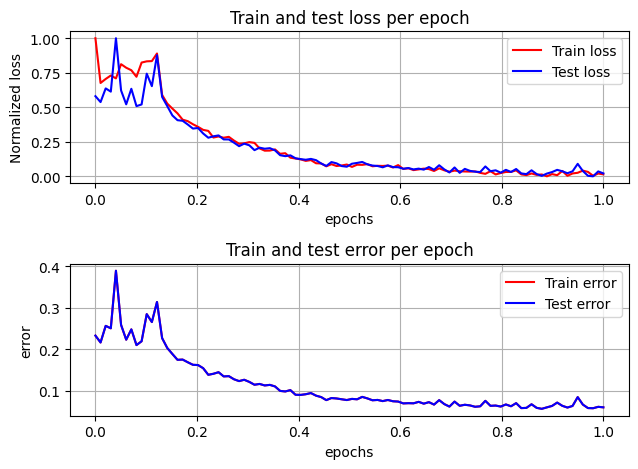

Epoch 0 | Loss train: 0.3459798398017883 | Loss test: 0.2678696196230631 | lr = 0.01
Epoch 10 | Loss train: 0.2726698684692383 | Loss test: 0.26773065387729617 | lr = 0.01
Epoch 20 | Loss train: 0.23167423424124717 | Loss test: 0.2317471909854147 | lr = 0.001
Epoch 30 | Loss train: 0.1787257086634636 | Loss test: 0.17615304485199942 | lr = 0.001
Epoch 40 | Loss train: 0.16173973762989044 | Loss test: 0.16143637517141918 | lr = 0.001
Epoch 50 | Loss train: 0.13765144345164299 | Loss test: 0.12192633949101918 | lr = 0.001
Epoch 60 | Loss train: 0.12122047671675681 | Loss test: 0.11969669790021957 | lr = 0.001
Epoch 70 | Loss train: 0.10782955054938793 | Loss test: 0.1055820852754608 | lr = 0.001
Epoch 80 | Loss train: 0.1252688751220703 | Loss test: 0.10802033076447154 | lr = 0.001
Epoch 90 | Loss train: 0.09857231205701827 | Loss test: 0.10461872869304248 | lr = 0.0001
Epoch 100 | Loss train: 0.09645414251089096 | Loss test: 0.10348551720380783 | lr = 0.0001


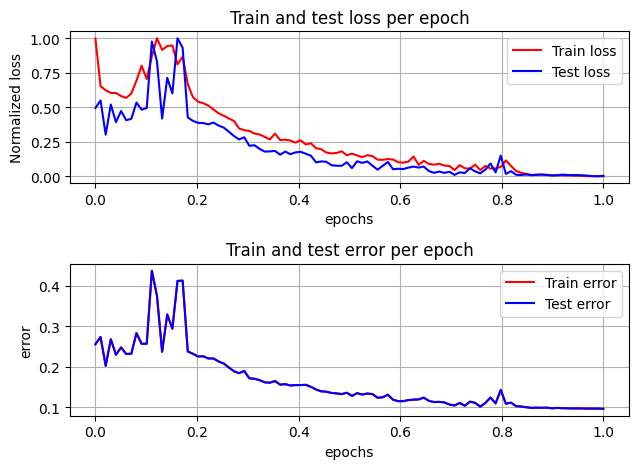

Epoch 0 | Loss train: 0.34626315569877625 | Loss test: 0.3049886399318302 | lr = 0.01
Epoch 10 | Loss train: 0.27782118412852286 | Loss test: 0.22183442849015433 | lr = 0.01
Epoch 20 | Loss train: 0.3052072970271111 | Loss test: 0.236345397574561 | lr = 0.01
Epoch 30 | Loss train: 0.14057633739709854 | Loss test: 0.1372957311215855 | lr = 0.001
Epoch 40 | Loss train: 0.11839468152821064 | Loss test: 0.12288527036943132 | lr = 0.001
Epoch 50 | Loss train: 0.11100705422461032 | Loss test: 0.12011509773040575 | lr = 0.001
Epoch 60 | Loss train: 0.11201892799139022 | Loss test: 0.10913150107103681 | lr = 0.001
Epoch 70 | Loss train: 0.09757796223461628 | Loss test: 0.10201548867755467 | lr = 0.001
Epoch 80 | Loss train: 0.09931570506095887 | Loss test: 0.09083068252555908 | lr = 0.001
Epoch 90 | Loss train: 0.0844717278778553 | Loss test: 0.09505775304777282 | lr = 0.001
Epoch 100 | Loss train: 0.11744040803611279 | Loss test: 0.1113363341206596 | lr = 0.001


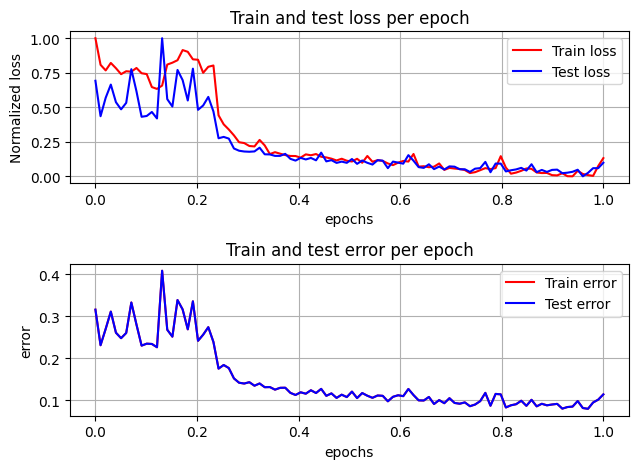

Epoch 0 | Loss train: 0.3334877901673317 | Loss test: 0.3212119149310248 | lr = 0.01
Epoch 10 | Loss train: 0.3100446382761002 | Loss test: 0.3361695283462131 | lr = 0.01
Epoch 20 | Loss train: 0.15465389239788055 | Loss test: 0.1416762357666379 | lr = 0.001
Epoch 30 | Loss train: 0.1309301331937313 | Loss test: 0.11890553789479393 | lr = 0.001
Epoch 40 | Loss train: 0.11767696517705917 | Loss test: 0.10025019925974664 | lr = 0.001
Epoch 50 | Loss train: 0.1074149659872055 | Loss test: 0.0977595987774077 | lr = 0.001
Epoch 60 | Loss train: 0.1070060514062643 | Loss test: 0.09844395098468614 | lr = 0.001
Epoch 70 | Loss train: 0.09862428076565266 | Loss test: 0.08504290311109453 | lr = 0.001
Epoch 80 | Loss train: 0.0907590036392212 | Loss test: 0.07941712326710186 | lr = 0.001
Epoch 90 | Loss train: 0.07606625951826572 | Loss test: 0.0668274112755344 | lr = 0.001
Epoch 100 | Loss train: 0.06933284957706928 | Loss test: 0.07018697043023413 | lr = 0.001


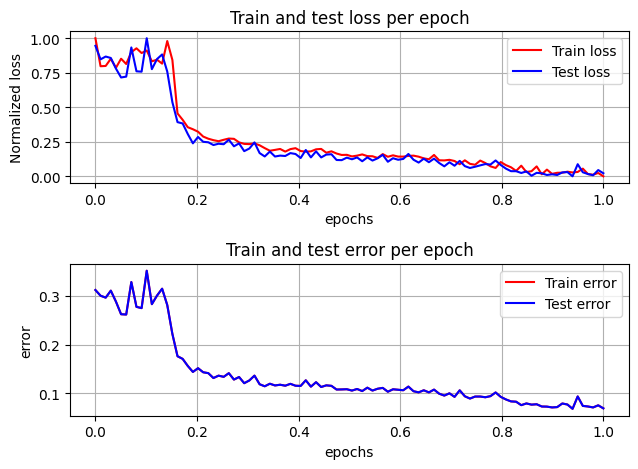

Epoch 0 | Loss train: 0.34081397706270217 | Loss test: 0.29193242934961167 | lr = 0.01
Epoch 10 | Loss train: 0.30439645844697955 | Loss test: 0.3470626033487774 | lr = 0.01
Epoch 20 | Loss train: 0.2248453068137169 | Loss test: 0.23524837988236594 | lr = 0.001
Epoch 30 | Loss train: 0.1871594120711088 | Loss test: 0.1974725429973905 | lr = 0.001
Epoch 40 | Loss train: 0.15833996826410293 | Loss test: 0.17247157804076635 | lr = 0.001
Epoch 50 | Loss train: 0.13059531511366368 | Loss test: 0.14626026821751442 | lr = 0.001
Epoch 60 | Loss train: 0.10532438522577285 | Loss test: 0.11132333640541349 | lr = 0.001
Epoch 70 | Loss train: 0.10234308651089669 | Loss test: 0.09274583641025755 | lr = 0.001
Epoch 80 | Loss train: 0.08714399284869433 | Loss test: 0.0885828769514485 | lr = 0.001
Epoch 90 | Loss train: 0.06860284115374088 | Loss test: 0.061729201455674475 | lr = 0.001
Epoch 100 | Loss train: 0.062476283170282844 | Loss test: 0.06702684268118843 | lr = 0.001


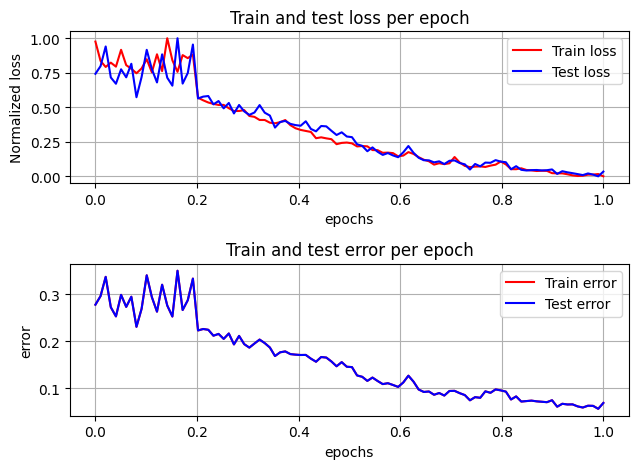

Completed CV with num splits: 5 and final error 0.08143351823091508
Epoch 0 | Loss train: 0.3321650753291651 | lr = 0.01
Epoch 10 | Loss train: 0.2915411976912913 | lr = 0.01
Epoch 20 | Loss train: 0.28812725563494923 | lr = 0.01
Epoch 30 | Loss train: 0.3494852054328583 | lr = 0.01
Epoch 40 | Loss train: 0.19791817926941588 | lr = 0.001
Epoch 50 | Loss train: 0.16642273231721916 | lr = 0.001
Epoch 60 | Loss train: 0.16003546787622258 | lr = 0.001
Epoch 70 | Loss train: 0.1340414437289817 | lr = 0.001
Epoch 80 | Loss train: 0.11929235118218123 | lr = 0.001
Epoch 90 | Loss train: 0.09931948848854238 | lr = 0.001
Epoch 100 | Loss train: 0.09926154457342129 | lr = 0.001


In [ ]:
loss_fn = nn.MSELoss()
optimizer_params = {'lr':1e-2}
scheduler_params = {'mode':'min','factor':0.1,"patience":10}
model_params = {'input_size':input_len, 'output_size':output_len}
num_splits = 5
errors = cv_NN(model_class=tanhModel,model_params=model_params,X=X,y=y,splits=num_splits,loss_fn=loss_fn,optimizer_class=torch.optim.Adam,optimizer_params=optimizer_params,scheduler_class=lr_scheduler.ReduceLROnPlateau,scheduler_params=scheduler_params,device=device)
print(f"Completed CV with num splits: {num_splits} and final error {np.mean(errors)}")
tanh_loss = np.mean(errors)
# Instantiate the model
model_8 = tanhModel(**model_params)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_8.parameters(), **optimizer_params)

# Initialize the scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, **scheduler_params)

train_loss, train_err = train_test_model(epoch = 100,model = model_8, train_loader= train_whole_dataloader, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler, device=device,test=False)

save_model_info(model_8,os.path.join(new_folder_path,"tanhmodel"))

#### Sigmoid

$Sigmoid(x) = \frac{1}{1+exp(-x)}$

In [ ]:
class sigmoidModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_units = 128):
        super(sigmoidModel, self).__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(in_features= input_size, out_features= hidden_units),
            nn.Sigmoid(),
            nn.Linear(in_features= hidden_units, out_features= hidden_units),
            nn.Sigmoid(),
            nn.Linear(in_features= hidden_units, out_features= output_size),   
        )
    
    def forward(self, x):
        return self.linear_stack(x)

Epoch 0 | Loss train: 0.2779847469031811 | Loss test: 0.2156424978895793 | lr = 0.01
Epoch 10 | Loss train: 0.1595462672561407 | Loss test: 0.16583405352301067 | lr = 0.01
Epoch 20 | Loss train: 0.15258174923062323 | Loss test: 0.16588293335267476 | lr = 0.01
Epoch 30 | Loss train: 0.1629023185968399 | Loss test: 0.16567322777377236 | lr = 0.01
Epoch 40 | Loss train: 0.1566537155210972 | Loss test: 0.15376556984015874 | lr = 0.001
Epoch 50 | Loss train: 0.1071333328038454 | Loss test: 0.10448143323735586 | lr = 0.001
Epoch 60 | Loss train: 0.1048721151649952 | Loss test: 0.10063349975953026 | lr = 0.001
Epoch 70 | Loss train: 0.09449385587126016 | Loss test: 0.10317100483983282 | lr = 0.001
Epoch 80 | Loss train: 0.08711311078816653 | Loss test: 0.0852519589224978 | lr = 0.001
Epoch 90 | Loss train: 0.07737237434834242 | Loss test: 0.07909016328908149 | lr = 0.001
Epoch 100 | Loss train: 0.08793767559528351 | Loss test: 0.09227301582457527 | lr = 0.001


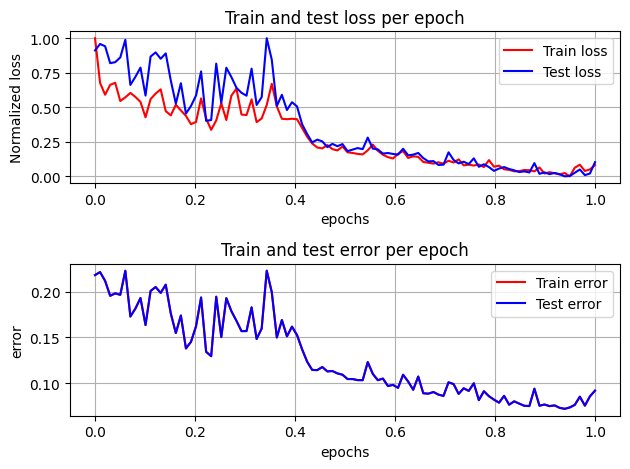

Epoch 0 | Loss train: 0.2805008744597435 | Loss test: 0.19359767389675928 | lr = 0.01
Epoch 10 | Loss train: 0.17273665517568587 | Loss test: 0.1618964620052822 | lr = 0.01
Epoch 20 | Loss train: 0.16557618647813796 | Loss test: 0.1567872782784795 | lr = 0.01
Epoch 30 | Loss train: 0.08238214354217052 | Loss test: 0.08770750871016866 | lr = 0.001
Epoch 40 | Loss train: 0.07565163566172123 | Loss test: 0.07503638389919486 | lr = 0.001
Epoch 50 | Loss train: 0.07454640036076307 | Loss test: 0.06895480766182854 | lr = 0.001
Epoch 60 | Loss train: 0.07093200273066759 | Loss test: 0.06893943421660907 | lr = 0.001
Epoch 70 | Loss train: 0.06382603957504034 | Loss test: 0.06669697047226013 | lr = 0.001
Epoch 80 | Loss train: 0.06167233292013407 | Loss test: 0.058867788681435204 | lr = 0.001
Epoch 90 | Loss train: 0.057050394274294376 | Loss test: 0.05555960420696508 | lr = 0.001
Epoch 100 | Loss train: 0.0533481812402606 | Loss test: 0.05357116496279126 | lr = 0.001


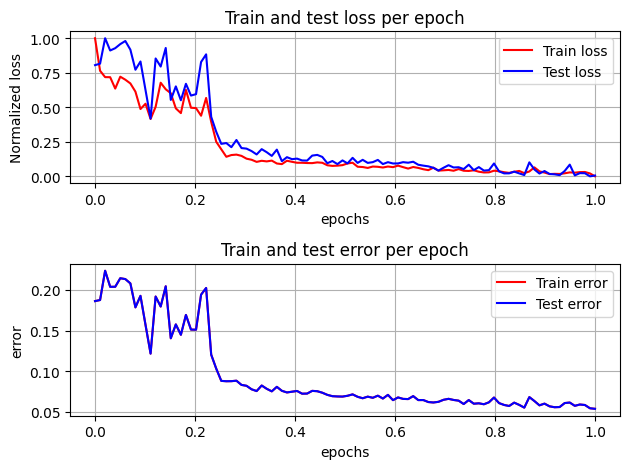

Epoch 0 | Loss train: 0.28011095854640006 | Loss test: 0.17060141454613398 | lr = 0.01
Epoch 10 | Loss train: 0.2084135160446167 | Loss test: 0.2018631874095826 | lr = 0.01
Epoch 20 | Loss train: 0.17120091265439988 | Loss test: 0.15349422300618792 | lr = 0.01
Epoch 30 | Loss train: 0.1514798593968153 | Loss test: 0.16470106762079967 | lr = 0.01
Epoch 40 | Loss train: 0.14378060001134874 | Loss test: 0.14616270434288753 | lr = 0.001
Epoch 50 | Loss train: 0.09227519987523555 | Loss test: 0.09779812129480499 | lr = 0.001
Epoch 60 | Loss train: 0.07500493025779724 | Loss test: 0.09433172873797871 | lr = 0.001
Epoch 70 | Loss train: 0.06912321631610394 | Loss test: 0.08101833180066138 | lr = 0.001
Epoch 80 | Loss train: 0.06659151197969913 | Loss test: 0.07836355582352668 | lr = 0.001
Epoch 90 | Loss train: 0.06253596214205026 | Loss test: 0.07305991016919651 | lr = 0.001
Epoch 100 | Loss train: 0.06392253006994725 | Loss test: 0.07750485923200373 | lr = 0.001


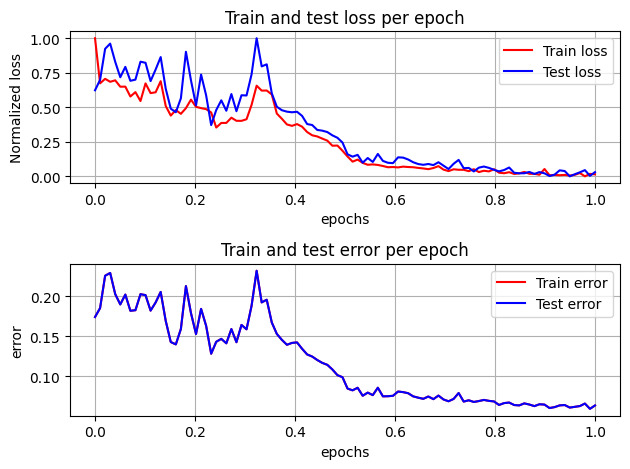

Epoch 0 | Loss train: 0.27893560963869096 | Loss test: 0.23149565146082923 | lr = 0.01
Epoch 10 | Loss train: 0.18616501224040985 | Loss test: 0.21352433839014598 | lr = 0.01
Epoch 20 | Loss train: 0.16747690811753274 | Loss test: 0.21453359344648937 | lr = 0.01
Epoch 30 | Loss train: 0.1075611426383257 | Loss test: 0.09557171940567001 | lr = 0.001
Epoch 40 | Loss train: 0.08319679813086986 | Loss test: 0.07986517977856454 | lr = 0.001
Epoch 50 | Loss train: 0.07751198688149452 | Loss test: 0.0743914700098454 | lr = 0.001
Epoch 60 | Loss train: 0.07414240837842226 | Loss test: 0.07178420780433549 | lr = 0.001
Epoch 70 | Loss train: 0.06888462964445352 | Loss test: 0.08262201969230933 | lr = 0.001
Epoch 80 | Loss train: 0.06362432695925235 | Loss test: 0.061235263884540585 | lr = 0.001
Epoch 90 | Loss train: 0.05455134153366089 | Loss test: 0.05201770403673724 | lr = 0.001
Epoch 100 | Loss train: 0.05540501678735018 | Loss test: 0.05114356750651958 | lr = 0.001


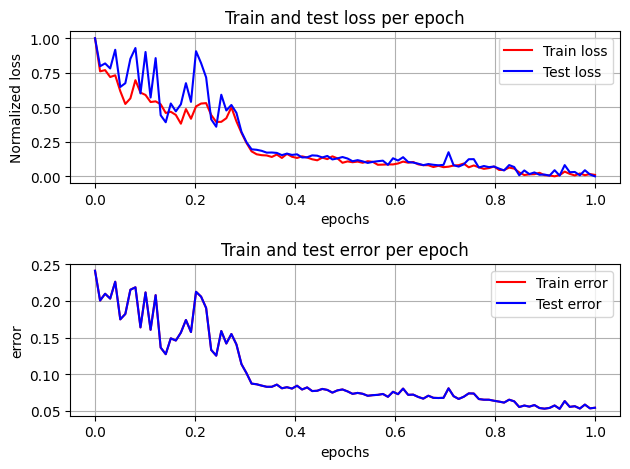

Epoch 0 | Loss train: 0.2766886799633503 | Loss test: 0.28750127672203 | lr = 0.01
Epoch 10 | Loss train: 0.19216207137703895 | Loss test: 0.15958154503078686 | lr = 0.01
Epoch 20 | Loss train: 0.14720995318889618 | Loss test: 0.17317242210819608 | lr = 0.01
Epoch 30 | Loss train: 0.15813292366266252 | Loss test: 0.15996608244521276 | lr = 0.01
Epoch 40 | Loss train: 0.08733344322443008 | Loss test: 0.09000134751910255 | lr = 0.001
Epoch 50 | Loss train: 0.06926220809668303 | Loss test: 0.06358118917024325 | lr = 0.001
Epoch 60 | Loss train: 0.07065142373740672 | Loss test: 0.07580396337878137 | lr = 0.001
Epoch 70 | Loss train: 0.06283732333034277 | Loss test: 0.05937497264572552 | lr = 0.001
Epoch 80 | Loss train: 0.058283724844455716 | Loss test: 0.05539547445045577 | lr = 0.001
Epoch 90 | Loss train: 0.05705721502751112 | Loss test: 0.05353810514012972 | lr = 0.001
Epoch 100 | Loss train: 0.05403998464345932 | Loss test: 0.0524802841541786 | lr = 0.001


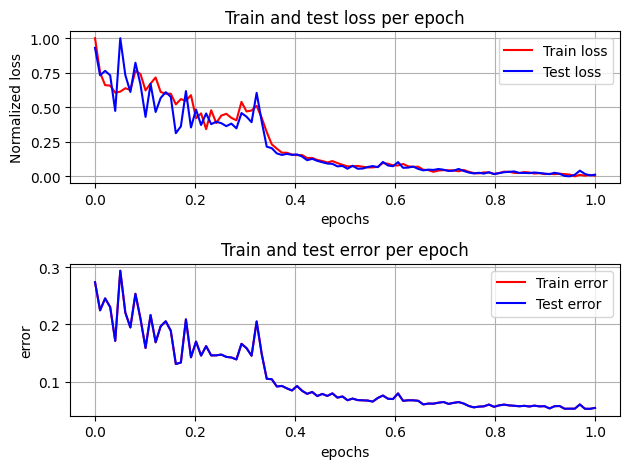

Completed CV with num splits: 5 and final error 0.06346489414572716
Epoch 0 | Loss train: 0.26423137308880923 | lr = 0.01
Epoch 10 | Loss train: 0.1760906665660322 | lr = 0.01
Epoch 20 | Loss train: 0.18328641088435443 | lr = 0.01
Epoch 30 | Loss train: 0.12225217987506534 | lr = 0.001
Epoch 40 | Loss train: 0.0835104869625058 | lr = 0.001
Epoch 50 | Loss train: 0.06819248611268144 | lr = 0.001
Epoch 60 | Loss train: 0.06596519117847609 | lr = 0.001
Epoch 70 | Loss train: 0.057592937371696525 | lr = 0.001
Epoch 80 | Loss train: 0.05784889035069714 | lr = 0.001
Epoch 90 | Loss train: 0.05458423946969235 | lr = 0.0001
Epoch 100 | Loss train: 0.054275807314597 | lr = 0.0001


In [ ]:
loss_fn = nn.MSELoss()
optimizer_params = {'lr':1e-2}
scheduler_params = {'mode':'min','factor':0.1,"patience":10}
model_params = {'input_size':input_len, 'output_size':output_len}
num_splits = 5
errors = cv_NN(model_class=sigmoidModel,model_params=model_params,X=X,y=y,splits=num_splits,loss_fn=loss_fn,optimizer_class=torch.optim.Adam,optimizer_params=optimizer_params,scheduler_class=lr_scheduler.ReduceLROnPlateau,scheduler_params=scheduler_params,device=device)
print(f"Completed CV with num splits: {num_splits} and final error {np.mean(errors)}")
sigmoid_loss = np.mean(errors)
# Instantiate the model
model_9 = sigmoidModel(**model_params)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_9.parameters(), **optimizer_params)

# Initialize the scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, **scheduler_params)

train_loss, train_err = train_test_model(epoch = 100,model = model_9, train_loader= train_whole_dataloader, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler, device=device,test=False)

save_model_info(model_9,os.path.join(new_folder_path,"sigmoid_model"))

### Αρχιτεκτονική 3

Μιας και βλέπουμε ότι τα καλύτερα αποτελέσματα τα δίνει το μοντέλο με συνάρτηση ενεργοποίησης LeakyReLU , θα δοκιμάσουμε να βάλουμε άλλο ένα layer για να δούμε πως θα επηρεαστουν τα αποτελέσματα.

In [ ]:
class LeakyReLUModel4(nn.Module):
    def __init__(self, input_size, output_size, hidden_units = 128):
        super(LeakyReLUModel4, self).__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(in_features= input_size, out_features= hidden_units),
            nn.LeakyReLU(0.1),
            nn.Linear(in_features= hidden_units, out_features= hidden_units),
            nn.LeakyReLU(0.1),
            nn.Linear(in_features= hidden_units, out_features= hidden_units),
            nn.LeakyReLU(0.1),
            nn.Linear(in_features= hidden_units, out_features= output_size)
        )
    
    def forward(self, x):
        return self.linear_stack(x)

Epoch 0 | Loss train: 10.48268977856636 | Loss test: 0.49936332778325154 | lr = 0.01
Epoch 10 | Loss train: 0.3721663600131869 | Loss test: 0.7880753160469116 | lr = 0.01
Epoch 20 | Loss train: 0.014960876371711493 | Loss test: 0.012222021847726807 | lr = 0.001
Epoch 30 | Loss train: 0.008791031667031348 | Loss test: 0.007649513715434642 | lr = 0.001
Epoch 40 | Loss train: 0.016408408821560444 | Loss test: 0.0061201016448201645 | lr = 0.001
Epoch 50 | Loss train: 0.006946016966365278 | Loss test: 0.005886080175904291 | lr = 0.001
Epoch 60 | Loss train: 0.006347035217098892 | Loss test: 0.005265273822708026 | lr = 0.001
Epoch 70 | Loss train: 0.006222385196015239 | Loss test: 0.004963946377208072 | lr = 0.001
Epoch 80 | Loss train: 0.005595700493082404 | Loss test: 0.004974117805619562 | lr = 0.001
Epoch 90 | Loss train: 0.0056039471412077544 | Loss test: 0.00491247217481335 | lr = 0.001
Epoch 100 | Loss train: 0.005424394140020013 | Loss test: 0.004988667732548146 | lr = 0.001


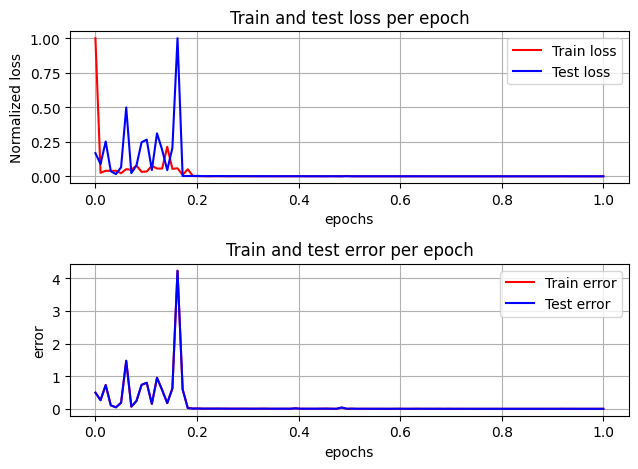

Epoch 0 | Loss train: 4.5383314831256865 | Loss test: 0.4820380073691171 | lr = 0.01
Epoch 10 | Loss train: 0.9968869365379214 | Loss test: 2.3445195905745977 | lr = 0.01
Epoch 20 | Loss train: 0.010746495662257076 | Loss test: 0.00960777943495602 | lr = 0.001
Epoch 30 | Loss train: 0.007645564845763147 | Loss test: 0.010503377950203324 | lr = 0.001
Epoch 40 | Loss train: 0.006857671824283898 | Loss test: 0.006969425668348632 | lr = 0.001
Epoch 50 | Loss train: 0.0063046126943081615 | Loss test: 0.005626765966770195 | lr = 0.001
Epoch 60 | Loss train: 0.007535695797763765 | Loss test: 0.005722670937843975 | lr = 0.001
Epoch 70 | Loss train: 0.005842327891848981 | Loss test: 0.005261331974040894 | lr = 0.001
Epoch 80 | Loss train: 0.005486372595652938 | Loss test: 0.005399477165488023 | lr = 0.001
Epoch 90 | Loss train: 0.0054362311456352475 | Loss test: 0.00506602786111808 | lr = 0.001
Epoch 100 | Loss train: 0.004019775134976953 | Loss test: 0.004021129140349489 | lr = 0.0001


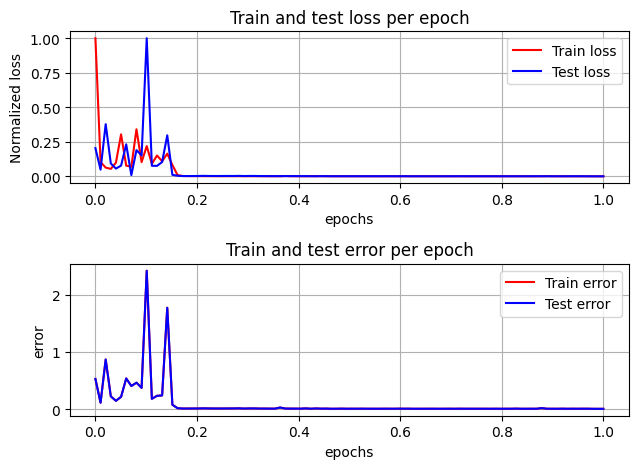

Epoch 0 | Loss train: 4.424577472120523 | Loss test: 4.1174829420116215 | lr = 0.01
Epoch 10 | Loss train: 0.6409056511521339 | Loss test: 0.599104357617242 | lr = 0.01
Epoch 20 | Loss train: 0.01752242976427078 | Loss test: 0.031235407890071943 | lr = 0.001
Epoch 30 | Loss train: 0.007414630979299545 | Loss test: 0.014658450511180691 | lr = 0.001
Epoch 40 | Loss train: 0.006458588824607432 | Loss test: 0.0944807658430248 | lr = 0.001
Epoch 50 | Loss train: 0.005944870264269412 | Loss test: 1.1275848982678283 | lr = 0.001
Epoch 60 | Loss train: 0.005683055870234966 | Loss test: 2.924333438258766 | lr = 0.001
Epoch 70 | Loss train: 0.005396453951485455 | Loss test: 9.041143418507769 | lr = 0.001
Epoch 80 | Loss train: 0.005233731119893491 | Loss test: 16.57989638742976 | lr = 0.001
Epoch 90 | Loss train: 0.005135811320040375 | Loss test: 31.004761545649092 | lr = 0.001
Epoch 100 | Loss train: 0.005241018313914538 | Loss test: 35.74224217820706 | lr = 0.001


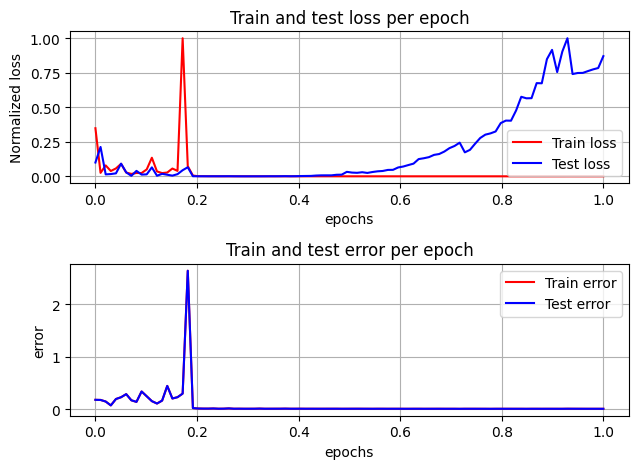

Epoch 0 | Loss train: 4.530991974890232 | Loss test: 1.0489331053362951 | lr = 0.01
Epoch 10 | Loss train: 0.5347476577684284 | Loss test: 0.10611939572152637 | lr = 0.01
Epoch 20 | Loss train: 0.014150545053184032 | Loss test: 0.010181731126818156 | lr = 0.001
Epoch 30 | Loss train: 0.00720546253118664 | Loss test: 0.007485927784785865 | lr = 0.001
Epoch 40 | Loss train: 0.006900231246836483 | Loss test: 0.006413211565582998 | lr = 0.001
Epoch 50 | Loss train: 0.005975398937240243 | Loss test: 0.006091044384187886 | lr = 0.001
Epoch 60 | Loss train: 0.006112448432482779 | Loss test: 0.006422678995434018 | lr = 0.001
Epoch 70 | Loss train: 0.006004683588631451 | Loss test: 0.006520955150740014 | lr = 0.001
Epoch 80 | Loss train: 0.005744502481073141 | Loss test: 0.005797384110915046 | lr = 0.001
Epoch 90 | Loss train: 0.003985994036775083 | Loss test: 0.004115125992231899 | lr = 0.0001
Epoch 100 | Loss train: 0.0038859395943582056 | Loss test: 0.004061582058461176 | lr = 0.0001


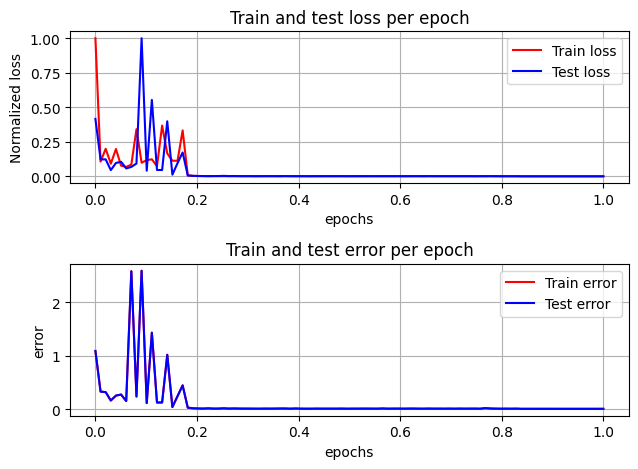

Epoch 0 | Loss train: 4.523842059791088 | Loss test: 0.16483402618813137 | lr = 0.01
Epoch 10 | Loss train: 1.2627479193881155 | Loss test: 0.09504840576222964 | lr = 0.01
Epoch 20 | Loss train: 0.06820371821522712 | Loss test: 0.016365146914881373 | lr = 0.001
Epoch 30 | Loss train: 0.008613586983643472 | Loss test: 0.0064676816774798295 | lr = 0.001
Epoch 40 | Loss train: 0.00799816969409585 | Loss test: 0.006076752625790144 | lr = 0.001
Epoch 50 | Loss train: 0.006480438101105392 | Loss test: 0.005486218602440897 | lr = 0.001
Epoch 60 | Loss train: 0.005856996459886432 | Loss test: 0.004826652547640223 | lr = 0.001
Epoch 70 | Loss train: 0.006344113554805517 | Loss test: 0.005117302187644537 | lr = 0.001
Epoch 80 | Loss train: 0.00656567224720493 | Loss test: 0.004739179870941573 | lr = 0.001
Epoch 90 | Loss train: 0.0045897675971500575 | Loss test: 0.003996614492424424 | lr = 0.0001
Epoch 100 | Loss train: 0.004030135250184685 | Loss test: 0.004057291917325486 | lr = 0.0001


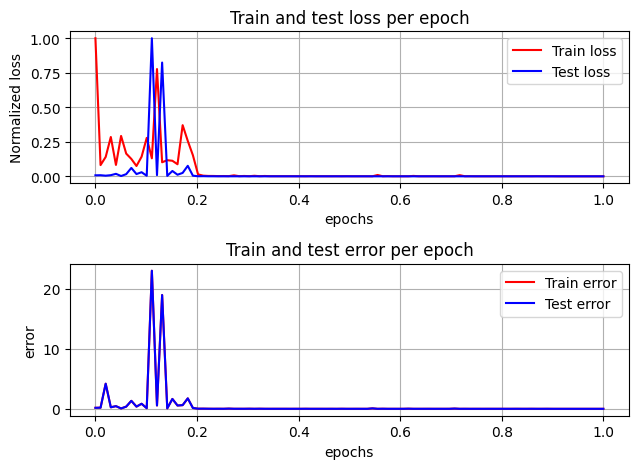

Completed CV with num splits: 5 and final error 0.004532857099547982
Epoch 0 | Loss train: 3.6645402128989706 | lr = 0.01
Epoch 10 | Loss train: 0.20910375304639148 | lr = 0.01
Epoch 20 | Loss train: 3.7038184684305526 | lr = 0.01
Epoch 30 | Loss train: 0.007608577148607983 | lr = 0.001
Epoch 40 | Loss train: 0.013872391802404588 | lr = 0.001
Epoch 50 | Loss train: 0.0057908451488128485 | lr = 0.001
Epoch 60 | Loss train: 0.005494605586194573 | lr = 0.001
Epoch 70 | Loss train: 0.005470604349385959 | lr = 0.001
Epoch 80 | Loss train: 0.005680268901897172 | lr = 0.001
Epoch 90 | Loss train: 0.0053134137941613655 | lr = 0.001
Epoch 100 | Loss train: 0.005279300404867283 | lr = 0.001


In [ ]:
loss_fn = nn.MSELoss()
optimizer_params = {'lr':1e-2}
scheduler_params = {'mode':'min','factor':0.1,"patience":10}
model_params = {'input_size':input_len, 'output_size':output_len}
num_splits = 5
errors = cv_NN(model_class=LeakyReLUModel4,model_params=model_params,X=X,y=y,splits=num_splits,loss_fn=loss_fn,optimizer_class=torch.optim.Adam,optimizer_params=optimizer_params,scheduler_class=lr_scheduler.ReduceLROnPlateau,scheduler_params=scheduler_params,device=device)
print(f"Completed CV with num splits: {num_splits} and final error {np.mean(errors)}")
leaky_relu_4_loss = np.mean(errors)
# Instantiate the model
model_10 = LeakyReLUModel4(**model_params)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_10.parameters(), **optimizer_params)

# Initialize the scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, **scheduler_params)

train_loss, train_err = train_test_model(epoch = 100,model = model_10, train_loader= train_whole_dataloader, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler, device=device,test=False)

save_model_info(model_10,os.path.join(new_folder_path,"leakyrelu_4"))

Παρατηρούμε ότι η επίδοση του μοντέλου δεν καλυτέρεψε, άρα δεν χρειάζεται να προσθέσουμε και άλλα layers.

### Αρχιτεκτονική 4

#### Dropout

Θα προσθέσουμε ένα άλλο επίπεδο που συνίσταται σε μοντέλα με μικρά datasets, το ```Dropout```. Αυτό, με πιθανότητα p "νεκρώνει" έναν νευρώνα, βοηθώντας έτσι το μοντέλο να κατανοήσει γενικότερα συμπεράσματα για τα δεδομένα που του δίνουμε.

In [ ]:
class LeakyReLUModelDropout(nn.Module):
    def __init__(self, input_size, output_size, hidden_units = 128):
        super(LeakyReLUModelDropout, self).__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(in_features= input_size, out_features= hidden_units),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.2),
            nn.Linear(in_features= hidden_units, out_features= hidden_units),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.1),
            nn.Linear(in_features= hidden_units, out_features= output_size)
        )
    
    def forward(self, x):
        return self.linear_stack(x)

Epoch 0 | Loss train: 50.459619504272936 | Loss test: 0.3347273433492297 | lr = 0.01
Epoch 10 | Loss train: 1.432494832277298 | Loss test: 0.5620154095074487 | lr = 0.01
Epoch 20 | Loss train: 0.08228747846186162 | Loss test: 0.03334646574443295 | lr = 0.001
Epoch 30 | Loss train: 0.04650062021613121 | Loss test: 0.021311589280172946 | lr = 0.001
Epoch 40 | Loss train: 0.0374839177057147 | Loss test: 0.031151169556237403 | lr = 0.001
Epoch 50 | Loss train: 0.030645508229732513 | Loss test: 0.015852370698537146 | lr = 0.001
Epoch 60 | Loss train: 0.031380834449082615 | Loss test: 0.024718396099550382 | lr = 0.001
Epoch 70 | Loss train: 0.02963317322731018 | Loss test: 0.03223963386364399 | lr = 0.001
Epoch 80 | Loss train: 0.04074739638343453 | Loss test: 0.03824424802783936 | lr = 0.001
Epoch 90 | Loss train: 0.02563373688235879 | Loss test: 0.02397262483894352 | lr = 0.001
Epoch 100 | Loss train: 0.02484677903354168 | Loss test: 0.03329853896820356 | lr = 0.001


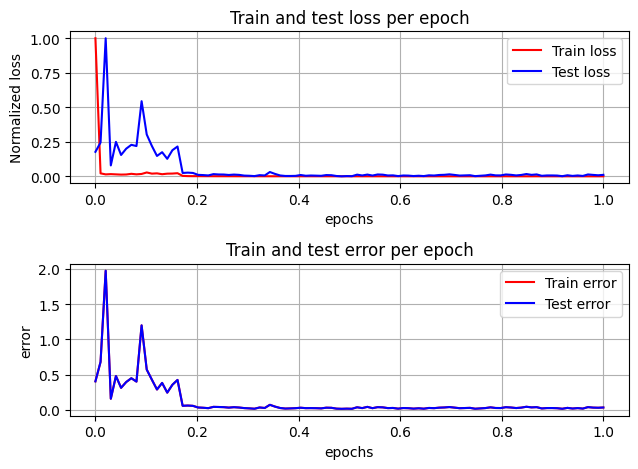

Epoch 0 | Loss train: 18.830351159453393 | Loss test: 0.5695472506303636 | lr = 0.01
Epoch 10 | Loss train: 1.025543600320816 | Loss test: 2.0889204229627336 | lr = 0.01
Epoch 20 | Loss train: 0.07420100377500058 | Loss test: 0.03137366973336727 | lr = 0.001
Epoch 30 | Loss train: 0.04333837389200926 | Loss test: 0.059178577115138374 | lr = 0.001
Epoch 40 | Loss train: 0.035932442829012874 | Loss test: 0.029380369872327835 | lr = 0.001
Epoch 50 | Loss train: 0.03961243840306997 | Loss test: 0.018567845476643433 | lr = 0.001
Epoch 60 | Loss train: 0.02798417942598462 | Loss test: 0.02515881521893399 | lr = 0.001
Epoch 70 | Loss train: 0.02726463271304965 | Loss test: 0.024642499311575815 | lr = 0.001
Epoch 80 | Loss train: 0.02857119857147336 | Loss test: 0.02203852418691866 | lr = 0.001
Epoch 90 | Loss train: 0.025919996086508034 | Loss test: 0.022066328600640336 | lr = 0.001
Epoch 100 | Loss train: 0.023841763876378538 | Loss test: 0.019163702851131795 | lr = 0.001


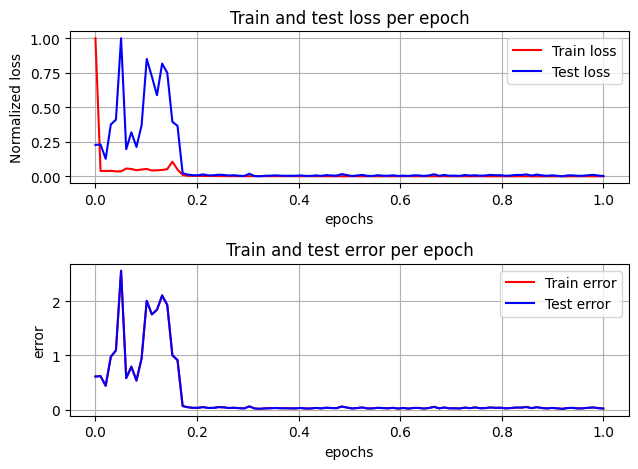

Epoch 0 | Loss train: 18.82984594374895 | Loss test: 0.5221486148380098 | lr = 0.01
Epoch 10 | Loss train: 0.9480676723718643 | Loss test: 4.858366156381274 | lr = 0.01
Epoch 20 | Loss train: 0.08043007592856884 | Loss test: 0.570068174145288 | lr = 0.001
Epoch 30 | Loss train: 0.045086245253682135 | Loss test: 0.15204630268826372 | lr = 0.001
Epoch 40 | Loss train: 0.03830320639535785 | Loss test: 0.44038715543195844 | lr = 0.001
Epoch 50 | Loss train: 0.03185701115056872 | Loss test: 0.5715541480670846 | lr = 0.001
Epoch 60 | Loss train: 0.027167644176632165 | Loss test: 0.6604763752529546 | lr = 0.001
Epoch 70 | Loss train: 0.02504472317546606 | Loss test: 0.6711564863189345 | lr = 0.001
Epoch 80 | Loss train: 0.02689731712266803 | Loss test: 0.7666767581351219 | lr = 0.001
Epoch 90 | Loss train: 0.02429451584815979 | Loss test: 0.4251345982922921 | lr = 0.001
Epoch 100 | Loss train: 0.02248420115187764 | Loss test: 0.19192455380800225 | lr = 0.001


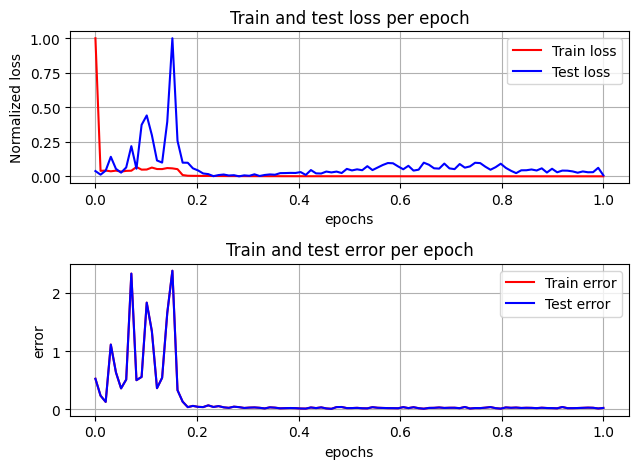

Epoch 0 | Loss train: 18.797285388171673 | Loss test: 0.44462141347309897 | lr = 0.01
Epoch 10 | Loss train: 0.9528831234574318 | Loss test: 0.9153206963387747 | lr = 0.01
Epoch 20 | Loss train: 0.05490639565140009 | Loss test: 0.021774157009545773 | lr = 0.001
Epoch 30 | Loss train: 0.04197466083616018 | Loss test: 0.03374538573599051 | lr = 0.001
Epoch 40 | Loss train: 0.034978482894599434 | Loss test: 0.02463661864518173 | lr = 0.001
Epoch 50 | Loss train: 0.03072967320308089 | Loss test: 0.028405490553095228 | lr = 0.001
Epoch 60 | Loss train: 0.03565862455591559 | Loss test: 0.038276012070358745 | lr = 0.001
Epoch 70 | Loss train: 0.026248406507074832 | Loss test: 0.01911325471860076 | lr = 0.001
Epoch 80 | Loss train: 0.024485085971653463 | Loss test: 0.032002387804880975 | lr = 0.001
Epoch 90 | Loss train: 0.02483205411955714 | Loss test: 0.023174282429473742 | lr = 0.001
Epoch 100 | Loss train: 0.014528921492397786 | Loss test: 0.01719577161092607 | lr = 0.0001


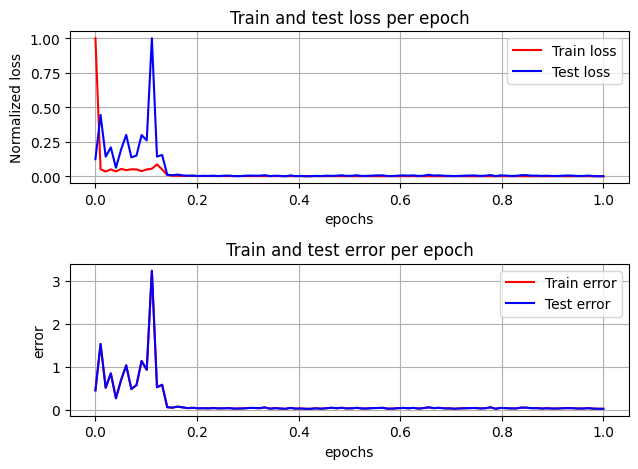

Epoch 0 | Loss train: 18.753057889521124 | Loss test: 0.5237601281158508 | lr = 0.01
Epoch 10 | Loss train: 1.0308538730740546 | Loss test: 0.22969772110855768 | lr = 0.01
Epoch 20 | Loss train: 0.06095192238688469 | Loss test: 0.06385094069299244 | lr = 0.001
Epoch 30 | Loss train: 0.04266489341109991 | Loss test: 0.06292276604781075 | lr = 0.001
Epoch 40 | Loss train: 0.0350043361261487 | Loss test: 0.03981889467982073 | lr = 0.001
Epoch 50 | Loss train: 0.03087228611111641 | Loss test: 0.031590936202851555 | lr = 0.001
Epoch 60 | Loss train: 0.02991148339211941 | Loss test: 0.03987011455354236 | lr = 0.001
Epoch 70 | Loss train: 0.029506482370197772 | Loss test: 0.03127066199741666 | lr = 0.001
Epoch 80 | Loss train: 0.025313064251095058 | Loss test: 0.023217144496147594 | lr = 0.001
Epoch 90 | Loss train: 0.024255809240043162 | Loss test: 0.017101996134789216 | lr = 0.001
Epoch 100 | Loss train: 0.024862250991165638 | Loss test: 0.01862701012324246 | lr = 0.001


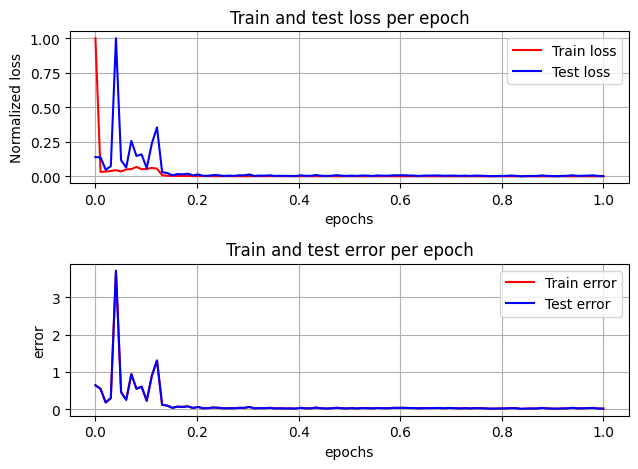

Completed CV with num splits: 5 and final error 0.023363248258829118
Epoch 0 | Loss train: 15.114751486304089 | lr = 0.01
Epoch 10 | Loss train: 0.9773743947664388 | lr = 0.01
Epoch 20 | Loss train: 0.060554118922200445 | lr = 0.001
Epoch 30 | Loss train: 0.04867171729429842 | lr = 0.001
Epoch 40 | Loss train: 0.03252453774439927 | lr = 0.001
Epoch 50 | Loss train: 0.02824407954590199 | lr = 0.001
Epoch 60 | Loss train: 0.025861504779289515 | lr = 0.001
Epoch 70 | Loss train: 0.024895259423163563 | lr = 0.001
Epoch 80 | Loss train: 0.02463967417375729 | lr = 0.001
Epoch 90 | Loss train: 0.023330151302793537 | lr = 0.001
Epoch 100 | Loss train: 0.01286539182620355 | lr = 0.0001


In [ ]:
loss_fn = nn.MSELoss()
optimizer_params = {'lr':1e-2}
scheduler_params = {'mode':'min','factor':0.1,"patience":10}
model_params = {'input_size':input_len, 'output_size':output_len}
num_splits = 5
errors = cv_NN(model_class=LeakyReLUModelDropout,model_params=model_params,X=X,y=y,splits=num_splits,loss_fn=loss_fn,optimizer_class=torch.optim.Adam,optimizer_params=optimizer_params,scheduler_class=lr_scheduler.ReduceLROnPlateau,scheduler_params=scheduler_params,device=device)
print(f"Completed CV with num splits: {num_splits} and final error {np.mean(errors)}")
dropout_loss = np.mean(errors)
# Instantiate the model
model_11 = LeakyReLUModelDropout(**model_params)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_11.parameters(), **optimizer_params)

# Initialize the scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, **scheduler_params)

train_loss, train_err = train_test_model(epoch = 100,model = model_11, train_loader= train_whole_dataloader, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler, device=device,test=False)

save_model_info(model_11,os.path.join(new_folder_path,"leakyrelu_4"))

### Αρχιτεκτονική 5

#### XGB

Θα χρησιμοποιήσουμε και τον γνωστό αλγόριθμο για regression XGB, με την βοήθεια του MultiOutputRegressor.

In [ ]:
X = info_tensor.reshape(len(info_tensor), -1)
y = rfid_label

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
# Fit the scaler on the training data and transform both the training and test sets
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
xgb_model = xgb.XGBRegressor(random_state=42, n_estimators=1500, learning_rate=0.01, eta = 0.2, tree_method = 'hist', device = 'cuda')

# Fit the model
multi_xgb = MultiOutputRegressor(xgb_model)
multi_xgb.fit(X_train_scaled, y_train) 

# Predict the model
y_pred = multi_xgb.predict(X_test_scaled)

xgb_loss = mean_squared_error(y_test, y_pred)

xgb_res = {'model_name': 'xgb_model', 'model_loss' : xgb_loss}

c:\Users\giama\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:21:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
c:\Users\giama\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:21:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
c:\Users\giama\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:23:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\context.cc:43: No visible GPU is found, setting device to CPU.
  warni

### Αρχιτεκτονική 6

#### Epochs

Θα δοκιμάσουμε επίσης αντί να δημιουργούμε batches να περνάμε τα data απευθείας στο μοντέλο.

Για την δοκιμή αυτή θα χρησιμοποιήσουμε το μοντέλο LeakyReLUModel4 με συνάρτηση ενεργοποίησης την LeakyReLU και 4 επίπεδα.

Δεν δημιουργώ συναρτήσεις αφού είναι μεμονομένη περίπτωση.

In [ ]:
# Instantiate the model
model_13 = LeakyReLUModel4(input_size=input_len, output_size=output_len)

# Define loss fucntion and optimizer
learning_rate = 1e-2


loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_13.parameters(), lr=learning_rate)

# Initialize the scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

In [ ]:
X = info_tensor.reshape(len(info_tensor), -1)
y = rfid_label

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
# Fit the scaler on the training data and transform both the training and test sets
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Set seed before defining model and optimizer
torch.manual_seed(42)  

# Move model to device **before** training
model_13.to(device)

# Convert data to PyTorch tensors and move to device
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32, device=device)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32, device=device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32, device=device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32, device=device)

# Set number of epochs
epochs = 1000  

# Training loop
for epoch in range(epochs):
    model_13.train()
    
    # Forward pass
    y_pred = model_13(X_train_tensor)

    # Compute loss
    loss = loss_fn(y_pred, y_train_tensor)  

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Evaluation
    model_13.eval()
    with torch.inference_mode():
        test_logits = model_13(X_test_tensor)
        test_loss = loss_fn(test_logits, y_test_tensor).detach()  # Ensure no gradients


    # Update learning rate scheduler
    if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
        scheduler.step(test_loss.detach())  
    else:
        scheduler.step()

    # Print every 100 epochs
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Train Loss: {loss:.5f} | Test Loss: {test_loss:.5f}")
print(f"Epoch: {epoch + 1} | Train Loss: {loss:.5f} | Test Loss: {test_loss:.5f}")

epoch_res = {'model_name': 'LeakyReLU4_noBatches', 'model_loss' : test_loss.cpu().item()}
save_model_info(model_13,os.path.join(new_folder_path,epoch_res["model_name"]))

Epoch: 0 | Train Loss: 2.39383 | Test Loss: 10.36479
Epoch: 100 | Train Loss: 0.11469 | Test Loss: 0.11097
Epoch: 200 | Train Loss: 0.02189 | Test Loss: 0.02206
Epoch: 300 | Train Loss: 0.01296 | Test Loss: 0.01328
Epoch: 400 | Train Loss: 0.01190 | Test Loss: 0.01224
Epoch: 500 | Train Loss: 0.01165 | Test Loss: 0.01198
Epoch: 600 | Train Loss: 0.01140 | Test Loss: 0.01171
Epoch: 700 | Train Loss: 0.01115 | Test Loss: 0.01144
Epoch: 800 | Train Loss: 0.01088 | Test Loss: 0.01115
Epoch: 900 | Train Loss: 0.01063 | Test Loss: 0.01088
Epoch: 1000 | Train Loss: 0.01038 | Test Loss: 0.01062


## Results

In [ ]:
results = [{'model_name': 'leaky_relu', 'model_loss' : leaky_relu_loss.item()},
           {'model_name': 'leaky_relu_4','model_loss': leaky_relu_4_loss.item()},
           {'model_name': 'relu','model_loss':relu_model_loss.item()},
           {'model_name':'relu64','model_loss':relu_model_64_loss.item()},
           {'model_name':'relu256','model_loss':relu_model_256_loss.item()},
           {'model_name':'dropout','model_loss':dropout_loss.item()},
           {'model_name': 'sigmoid','model_loss':sigmoid_loss.item()},
           {'model_name':'tanh','model_loss':tanh_loss.item()}]
print(results)

[{'model_name': 'leaky_relu', 'model_loss': 0.006425520963966846}, {'model_name': 'leaky_relu_4', 'model_loss': 0.004532857099547982}, {'model_name': 'relu', 'model_loss': 0.01071331612765789}, {'model_name': 'relu64', 'model_loss': 0.009428187739104033}, {'model_name': 'relu256', 'model_loss': 0.013620735704898834}, {'model_name': 'dropout', 'model_loss': 0.023363248258829118}, {'model_name': 'sigmoid', 'model_loss': 0.06346489414572716}, {'model_name': 'tanh', 'model_loss': 0.08143351823091508}]


In [ ]:

compare_results = pd.DataFrame(results)
compare_results = compare_results._append(xgb_res, ignore_index = True)
compare_results = compare_results._append(epoch_res, ignore_index = True)
compare_results['model_loss'] = compare_results['model_loss'].apply(np.sqrt)
compare_results.sort_values(by = 'model_loss', ascending= True, inplace= True)
compare_results

,model_name,model_loss
1,leaky_relu_4,0.067326
8,xgb_model,0.079057
0,leaky_relu,0.080159
3,relu64,0.097099
9,LeakyReLU4_noBatches,0.103063
2,relu,0.103505
4,relu256,0.116708
5,dropout,0.152850
6,sigmoid,0.251922
7,tanh,0.285366


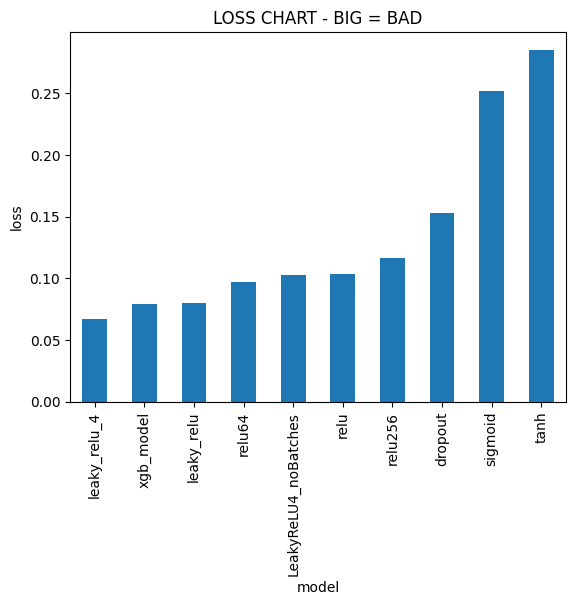

In [ ]:
# Visualize our model results
compare_results.set_index("model_name")["model_loss"].plot(kind="bar")
plt.xlabel("model")
plt.ylabel("loss")
plt.title("LOSS CHART - BIG = BAD")
plt.show()

***